# Future prediction to provide the vaccination and treatment on right time

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Activation,Dense,Dropout
%matplotlib inline
scaler = MinMaxScaler()
from keras.callbacks import EarlyStopping

In [2]:
data_path = 'all_total.json'
f = open(data_path)
# returns JSON object as a dictionary
data = json.load(f)
total_cases_list = []
new_cases_list = []

pre_total_cases = 0
for row in data["rows"]:
    if "total_confirmed_cases" in row["key"]:
        temp_list = []
        temp_list.append(row["key"][0][0:10]) # Appending the date (the time part is trimmed)
        temp_list.append(row["value"]) # Appending the value on that date
        total_cases_list.append(temp_list)
        
        temp_list_2 = []
        temp_list_2.append(row["key"][0][0:10])
        temp_list_2.append((row["value"] - pre_total_cases)) # Appending the value on that date
        new_cases_list.append(temp_list_2)
        
        pre_total_cases = row["value"]
    
df_total = pd.DataFrame(total_cases_list, columns = ["Date", "Total Cases"])
df_new = pd.DataFrame(new_cases_list, columns = ["Date", "New Cases"])

In [3]:
df_total = df_total.set_index("Date")
df_new = df_new.set_index("Date")

In [4]:
#deleting two faulty values
df_total.drop('2021-09-16', inplace=True, axis=0)
df_total.drop('2021-09-17', inplace=True, axis=0)
df_total.drop('2021-07-21', inplace=True, axis=0)
df_total.drop('2021-07-22', inplace=True, axis=0)
df_new.drop('2021-09-16', inplace=True, axis=0)
df_new.drop('2021-09-17', inplace=True, axis=0)
df_new.drop('2021-07-21', inplace=True, axis=0)
df_new.drop('2021-07-22', inplace=True, axis=0)

In [5]:
df_new

New Cases
Date                 
2020-01-30          1
2020-02-02          1
2020-02-03          1
2020-03-02          2
2020-03-03          1
...               ...
2022-01-06      90928
2022-01-07     117100
2022-01-08     141986
2022-01-09     159632
2022-01-10     179723

[733 rows x 1 columns]

In [6]:
day = 90 # Number of days (window size)

In [7]:
k = 0
array = []
array_temp = []
train_data = []
train_labels = []
for i in range(len(df_new)):
    array_temp.append(df_new.iloc[i]['New Cases'])
array_temp = np.array(array_temp).reshape(-1,1)
array_temp = scaler.fit_transform(array_temp)
array_temp = array_temp.tolist()
for i in array_temp:
    array.append(i[0])
for i in range(len(array)):
    try:
        train_data.append(array[k:day+k]) # Creating inner lists with 'day' days of data
        train_labels.append([array[day+k]])
        k += 1
    except:
        break
length = max(map(len, train_data))
train_data=np.array([xi+[None]*(length-len(xi)) for xi in train_data]).astype('float32')
length = max(map(len, train_labels))
train_labels = np.array([xi+[None]*(length-len(xi)) for xi in train_labels]).astype('float32')

In [8]:
print(train_data.shape)
print(train_labels.shape)

(644, 90)
(643, 1)


In [9]:
train_data = train_data[:len(train_labels)]
train_data = np.expand_dims(train_data,1)
train_data.shape

(643, 1, 90)

In [10]:
train_data[1]

array([[2.41436260e-06, 2.41436260e-06, 4.82872520e-06, 2.41436260e-06,
        9.89888649e-05, 3.13867131e-05, 3.13867131e-05, 2.41436260e-06,
        2.41436260e-06, 9.65745039e-06, 9.65745039e-06, 2.41436260e-06,
        2.17292636e-05, 3.38010759e-05, 0.00000000e+00, 7.24308757e-06,
        9.65745039e-06, 2.65579874e-05, 0.00000000e+00, 2.41436260e-06,
        2.65579874e-05, 2.41436264e-05, 9.65745039e-06, 3.62154387e-05,
        2.41436260e-06, 1.44861751e-05, 5.31159749e-05, 6.76021518e-05,
        8.45026880e-05, 6.03590634e-05, 9.89888649e-05, 0.00000000e+00,
        8.69170544e-05, 7.24308775e-05, 0.00000000e+00, 1.03817591e-04,
        2.41436260e-06, 1.40033022e-04, 6.51877926e-05, 0.00000000e+00,
        1.03817591e-04, 1.06231950e-04, 1.03817591e-04, 1.08646316e-04,
        7.24308775e-05, 3.59740021e-04, 8.69170544e-05, 1.69005376e-04,
        1.08646316e-04, 1.13475042e-04, 3.23524582e-04, 3.71811824e-04,
        6.71192771e-04, 4.75629437e-04, 3.16281483e-04, 2.510937

In [11]:
train_labels[1]

array([0.0027741], dtype=float32)

In [12]:
def new_model():
    model = Sequential()
    model.add(LSTM(250,input_shape=(1,day)))
    model.add(Dropout(0.5))
    model.add(Dense(250,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(day,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.summary()
    return model

In [13]:
E = 1000
callback = EarlyStopping(monitor='loss', mode='min', patience=20)
model = new_model()
H = model.fit(train_data,train_labels,epochs=E, verbose=0, callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               341000    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 90)                22590     
                                                                 
 dropout_2 (Dropout)         (None, 90)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [14]:
def plot_points(plt, array, shift, steps, pre_x, pre_y):
  for x in range(0, len(array), steps):
    y_point = array[x]
    if isinstance(y_point, np.ndarray):
      y_point = y_point[0]
    
    # Annotate the point
    x_point = x + shift
    plt.scatter(x_point, y_point, color='black', s=10)
    plt.text(x_point, y_point, f'({round(x_point, pre_x)}, {round(y_point, pre_y)})', ha='center', va='bottom')

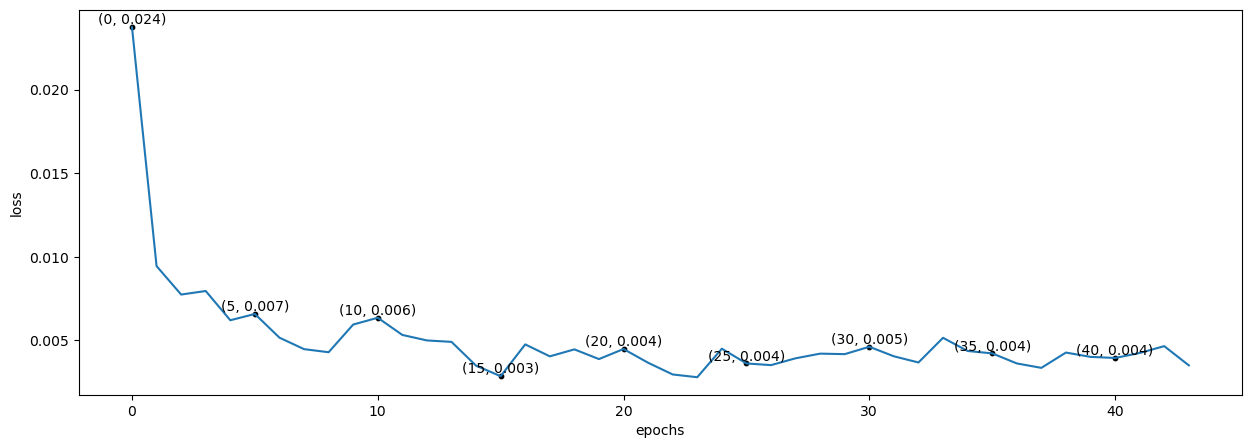

In [15]:
loss = H.history['loss']
epochs = range(0,len(loss))
plt.figure(figsize=(15,5))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(epochs,loss)
plot_points(plt, loss, 0, 5, 0, 3)

21/21 [==============================] - 1s 4ms/step


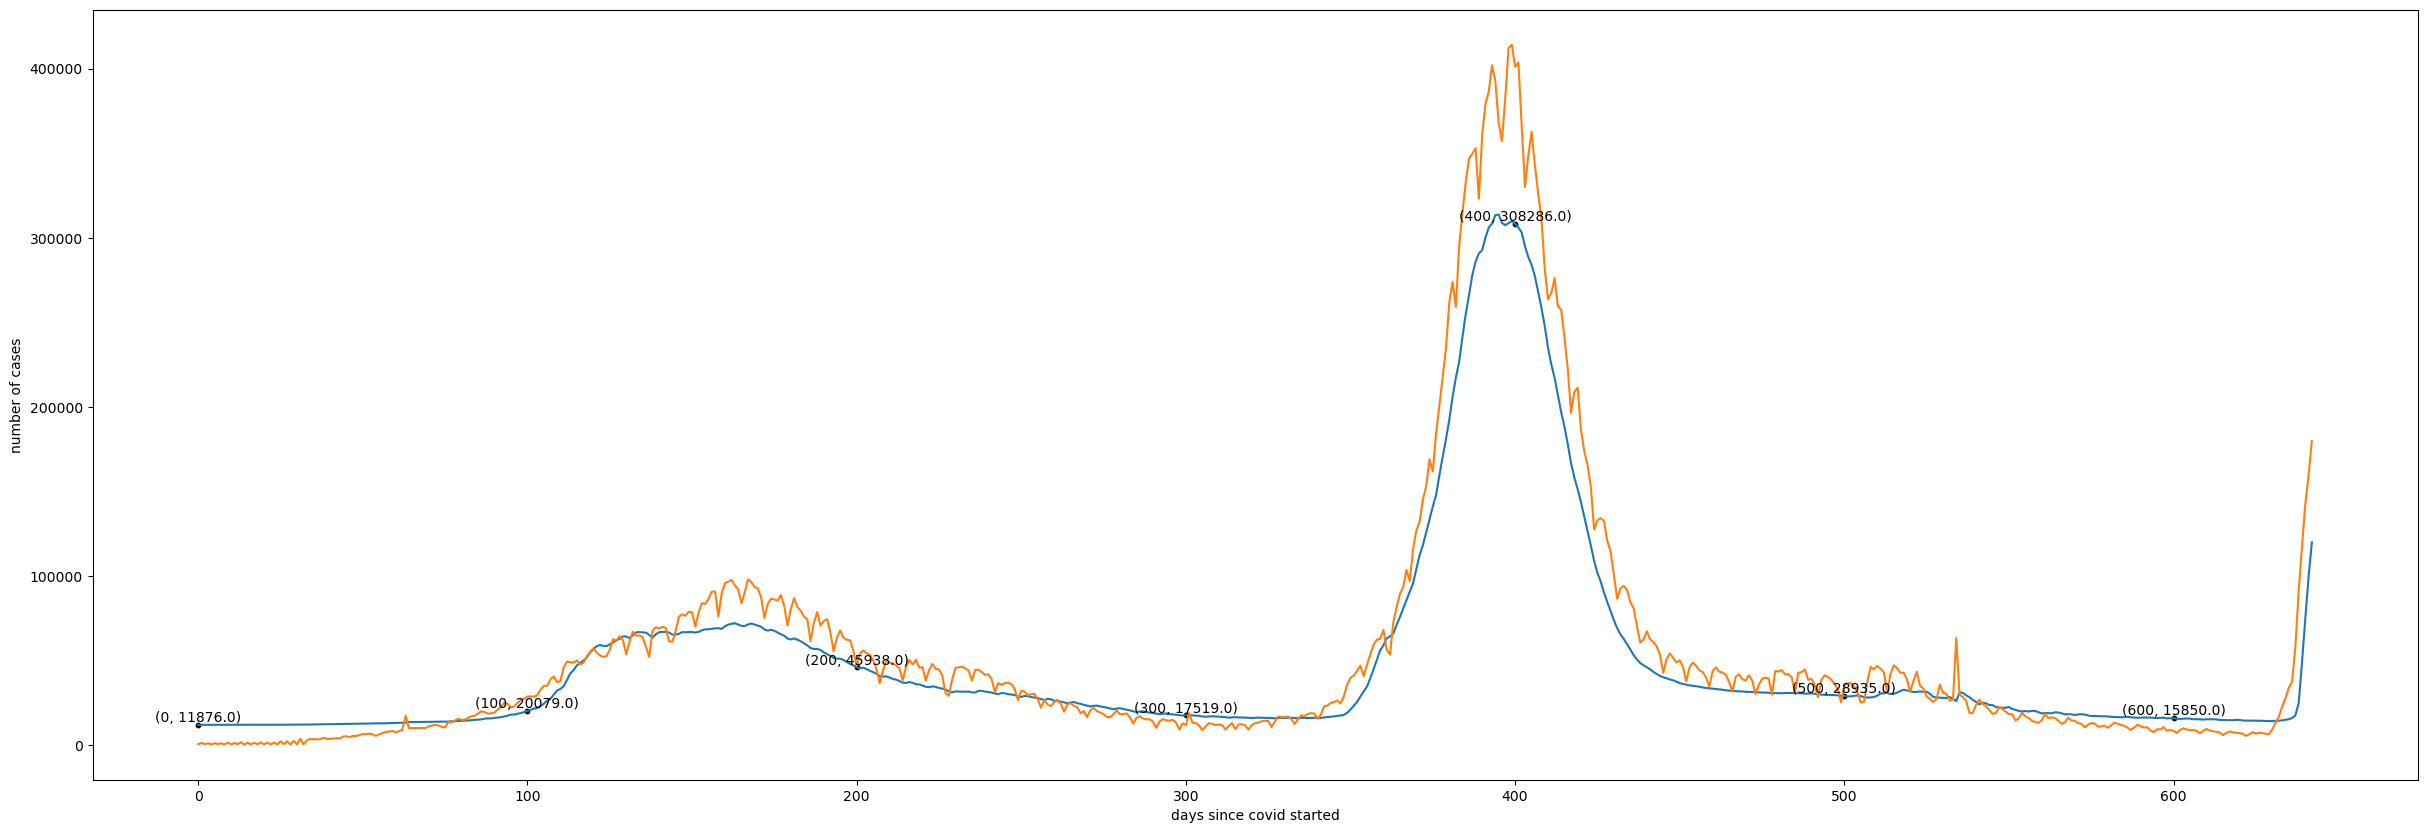

In [16]:
preds = scaler.inverse_transform(model.predict(train_data))
plt.figure(figsize=(30,10))
plt.xlabel("days since covid started")
plt.ylabel("number of cases")
plt.plot(preds,label='our predictions')
plt.plot(scaler.inverse_transform(train_labels),label='real values')
plot_points(plt, preds, 0, 100, 0, 0)

In [17]:
days_to_predict = 90
seed = array[-day:]
#seed

In [18]:
for _ in range(days_to_predict):
    current_days = seed[-day:]
    current_days = np.squeeze(current_days)
    current_days = np.expand_dims(current_days,0)
    current_days = np.expand_dims(current_days,0)
    pred = model.predict(current_days)
    seed = np.append(seed,pred)

1/1 [==============================] - 0s 30ms/step


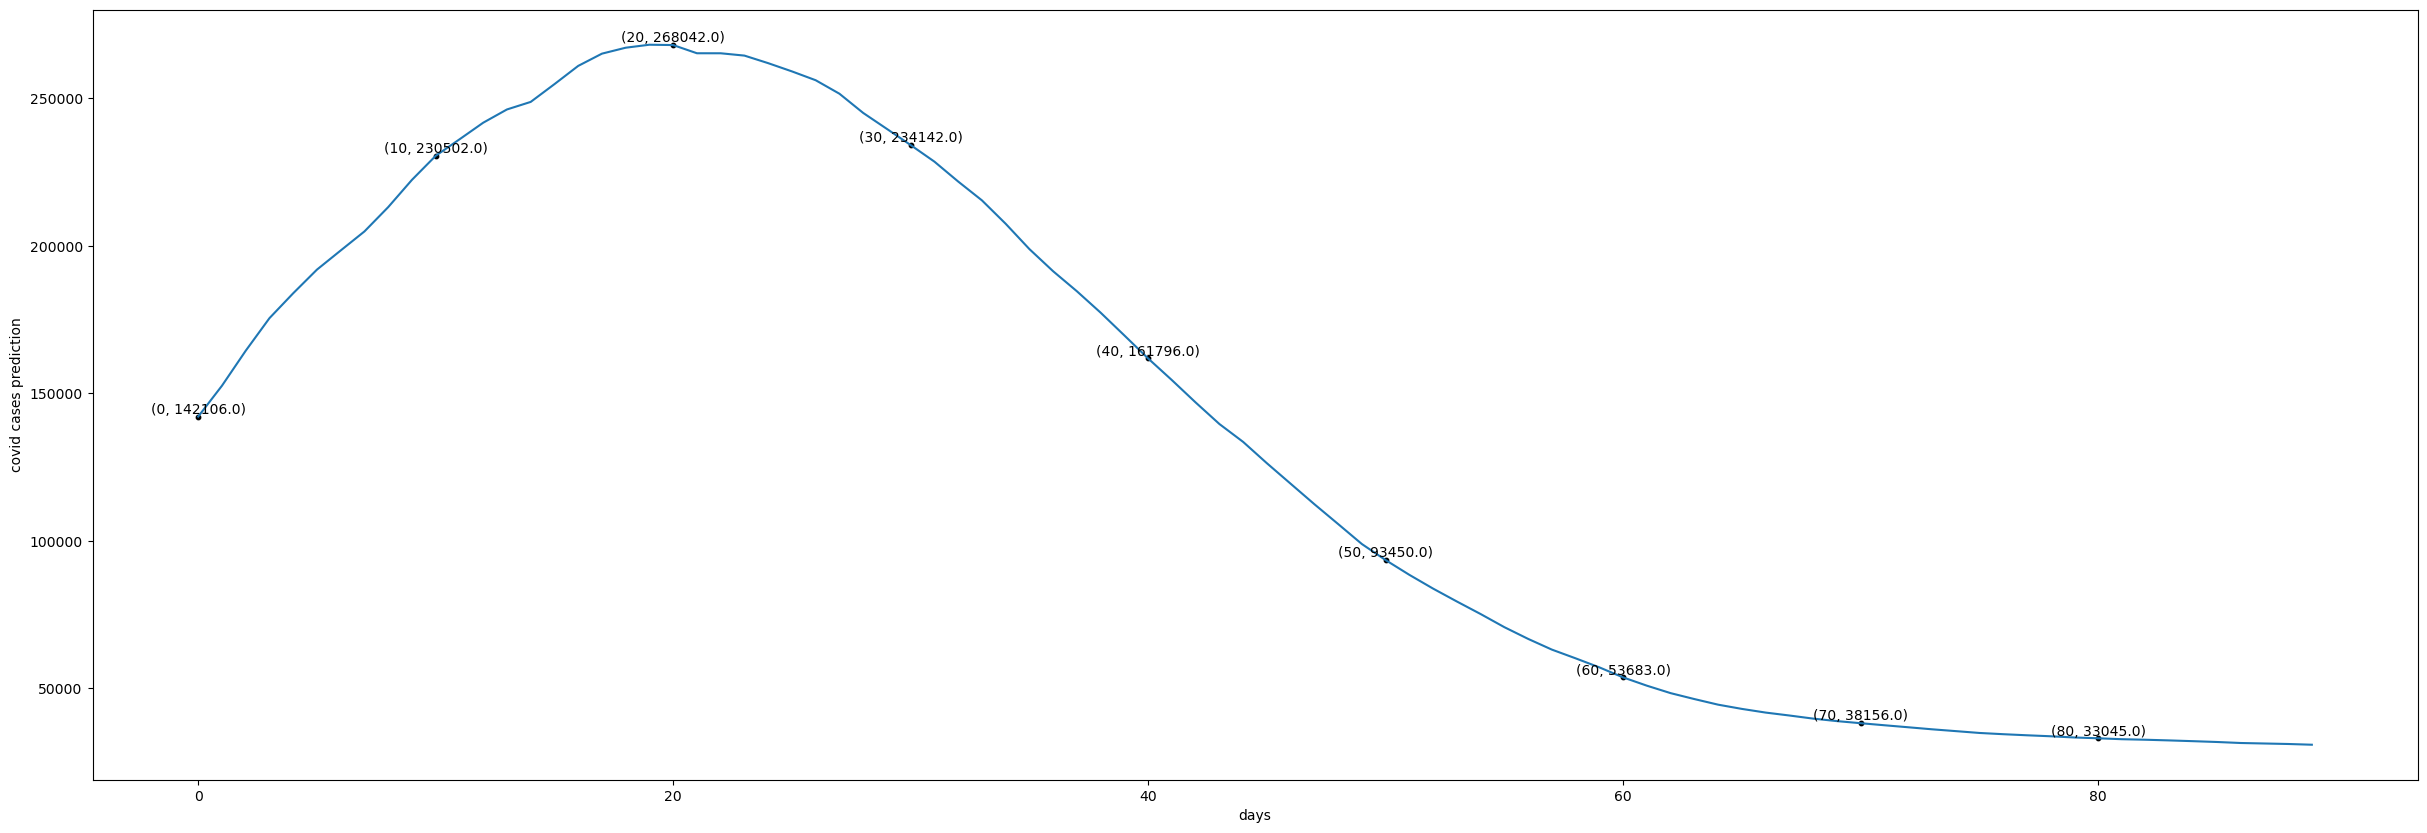

In [19]:
upcoming_days_prediction = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases prediction")
plt.plot(range(0,days_to_predict),upcoming_days_prediction)
plot_points(plt, upcoming_days_prediction, 0, 10, 0, 0)

Text(399, 414188.0, '(399, 414188)')

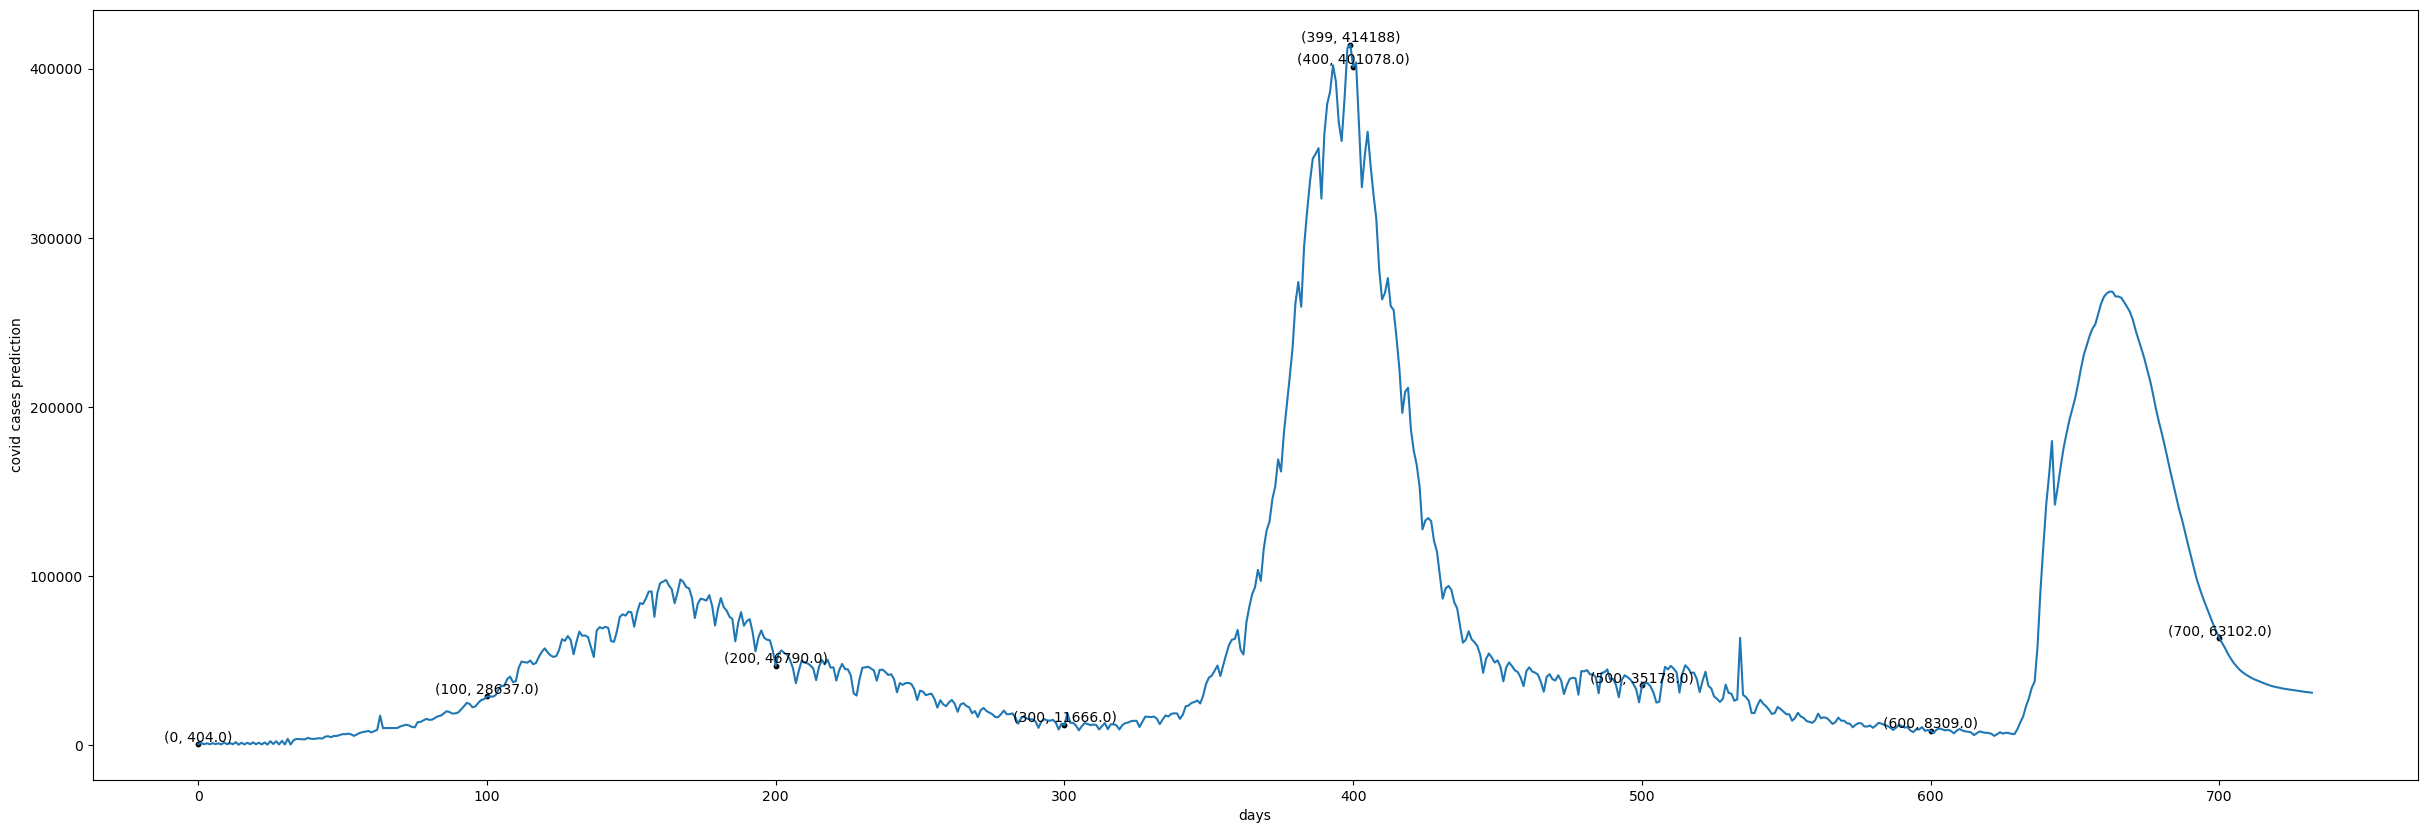

In [20]:
# Adding real values and predicted values together
arr_without_pred = scaler.inverse_transform(train_labels)
arr_pred = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
arr_with_pred = np.concatenate((arr_without_pred, arr_pred))
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases prediction")
plt.plot(arr_with_pred)

plot_points(plt, arr_with_pred, 0, 100, 0, 0)

# Maxima
y_max = np.max(arr_with_pred)
x_max = np.where(arr_with_pred == y_max)[0][0]
plt.scatter(x_max, y_max, color='black', s=10)
plt.text(x_max, y_max, f'({x_max:.0f}, {y_max:.0f})', ha='center', va='bottom')

In [21]:
total_new_cases = 0
for i in upcoming_days_prediction:
    total_new_cases += i[0]
    #print(i)
print("New Cases in upcoming", days_to_predict,"days:", int(total_new_cases))

New Cases in upcoming 90 days: 12132202


**Vaccination started in India on 16th January, 2022.**

In [22]:
from datetime import datetime

format = '%Y-%m-%d'
vaccine_start_date = '2021-01-16'
vaccine_start_date = datetime.strptime(vaccine_start_date, format).date()

In [23]:
pre_vaccination_total = []
pre_vaccination_new = []
post_vaccination_total = []
post_vaccination_new = []

cumulative_before_vaccination = 0
for (a, b) in zip(total_cases_list, new_cases_list):
    cur_date = datetime.strptime(a[0], format).date()
    if cur_date < vaccine_start_date:
        pre_vaccination_total.append(a[1])
        pre_vaccination_new.append(b[1])
        cumulative_before_vaccination = a[1]
    else:
        post_vaccination_total.append(a[1] - cumulative_before_vaccination)
        post_vaccination_new.append(b[1])

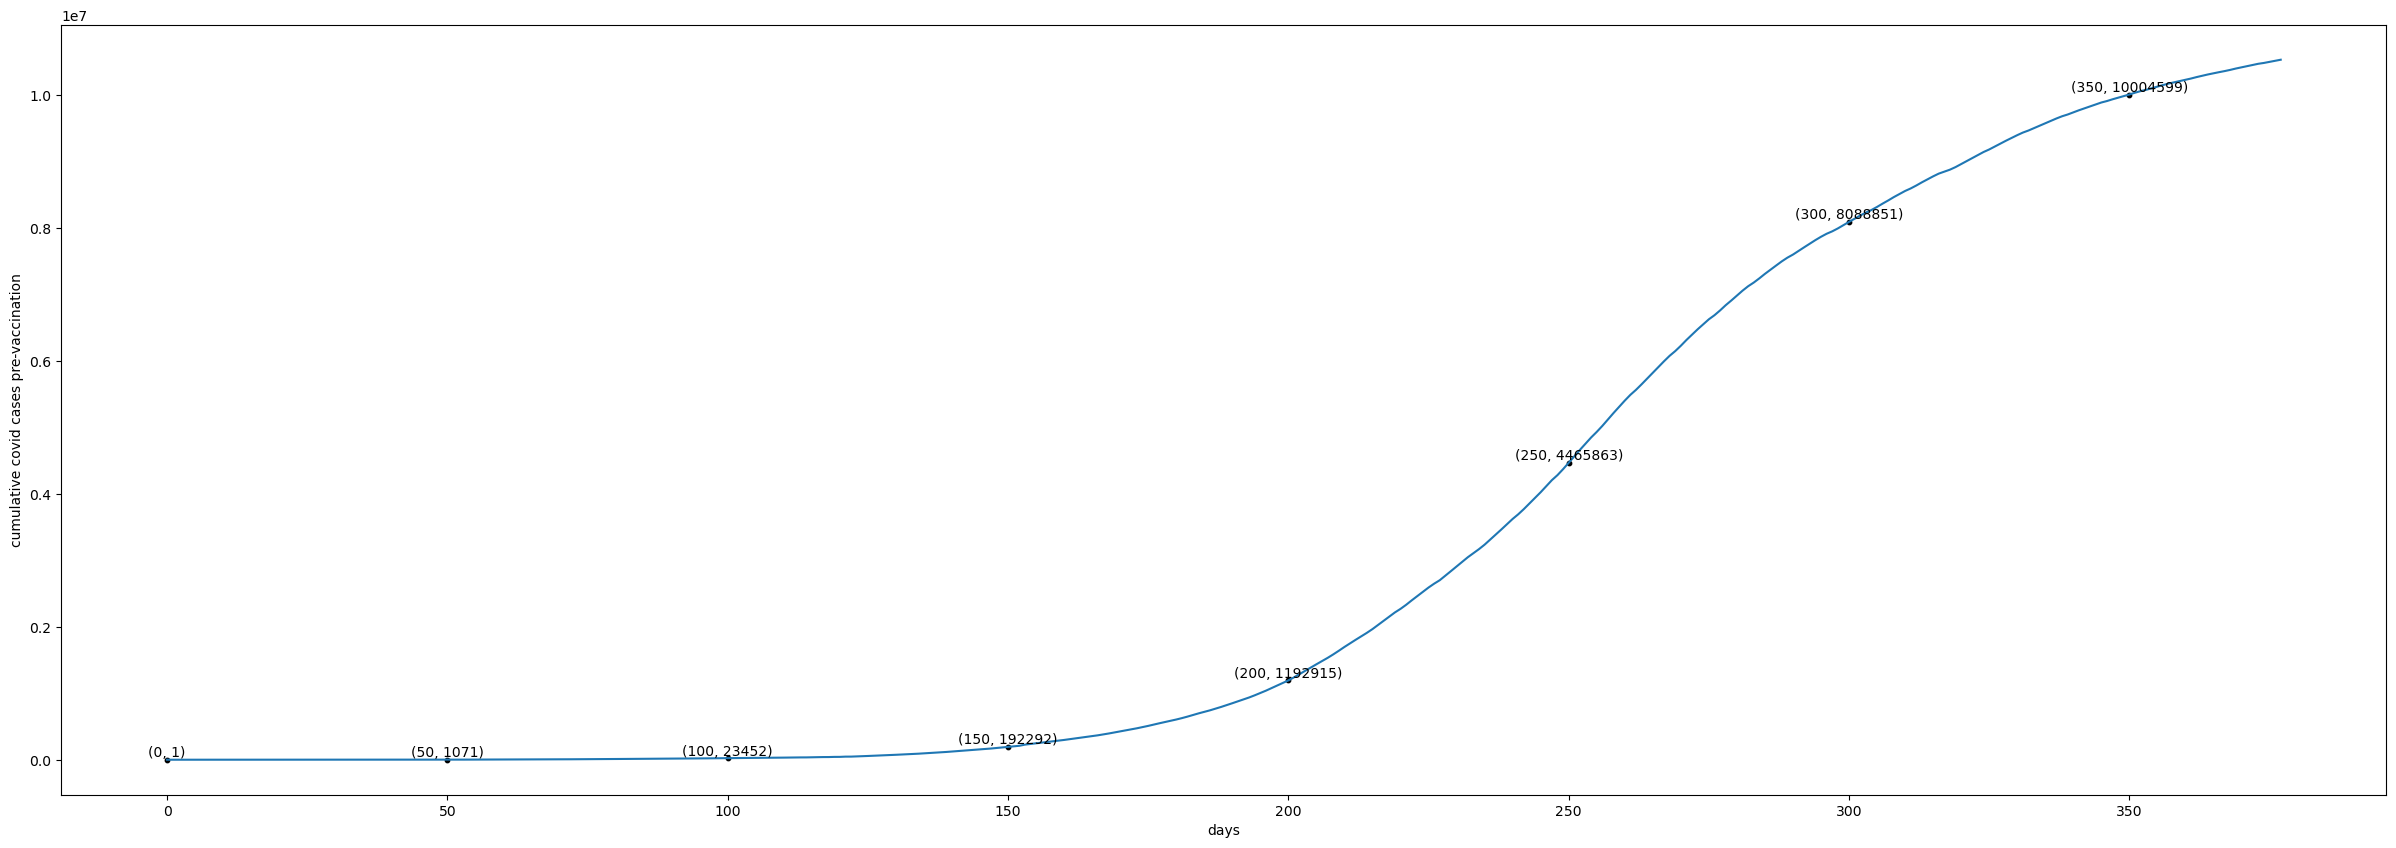

In [24]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("cumulative covid cases pre-vaccination")
plt.plot(pre_vaccination_total)
plot_points(plt, pre_vaccination_total, 0, 50, 0, 0)

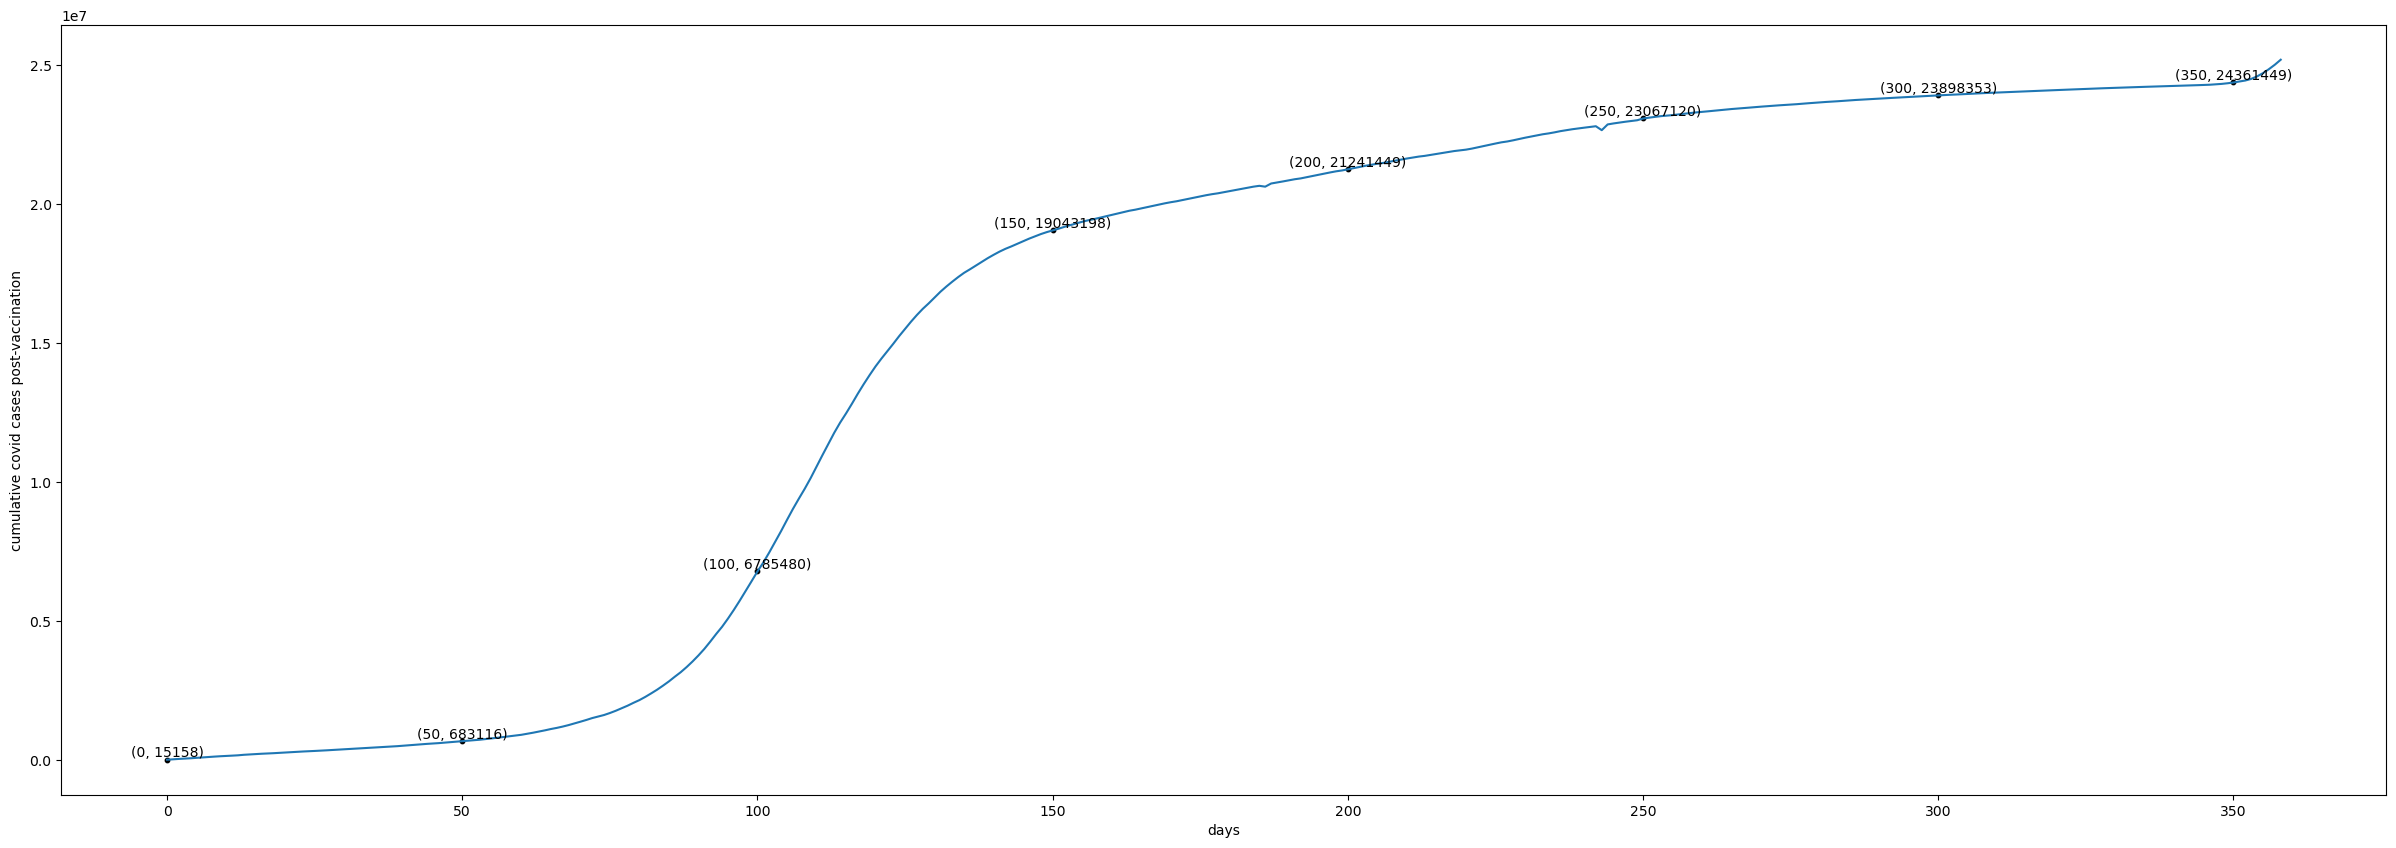

In [25]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("cumulative covid cases post-vaccination")
plt.plot(post_vaccination_total)
plot_points(plt, post_vaccination_total, 0, 50, 0, 0)

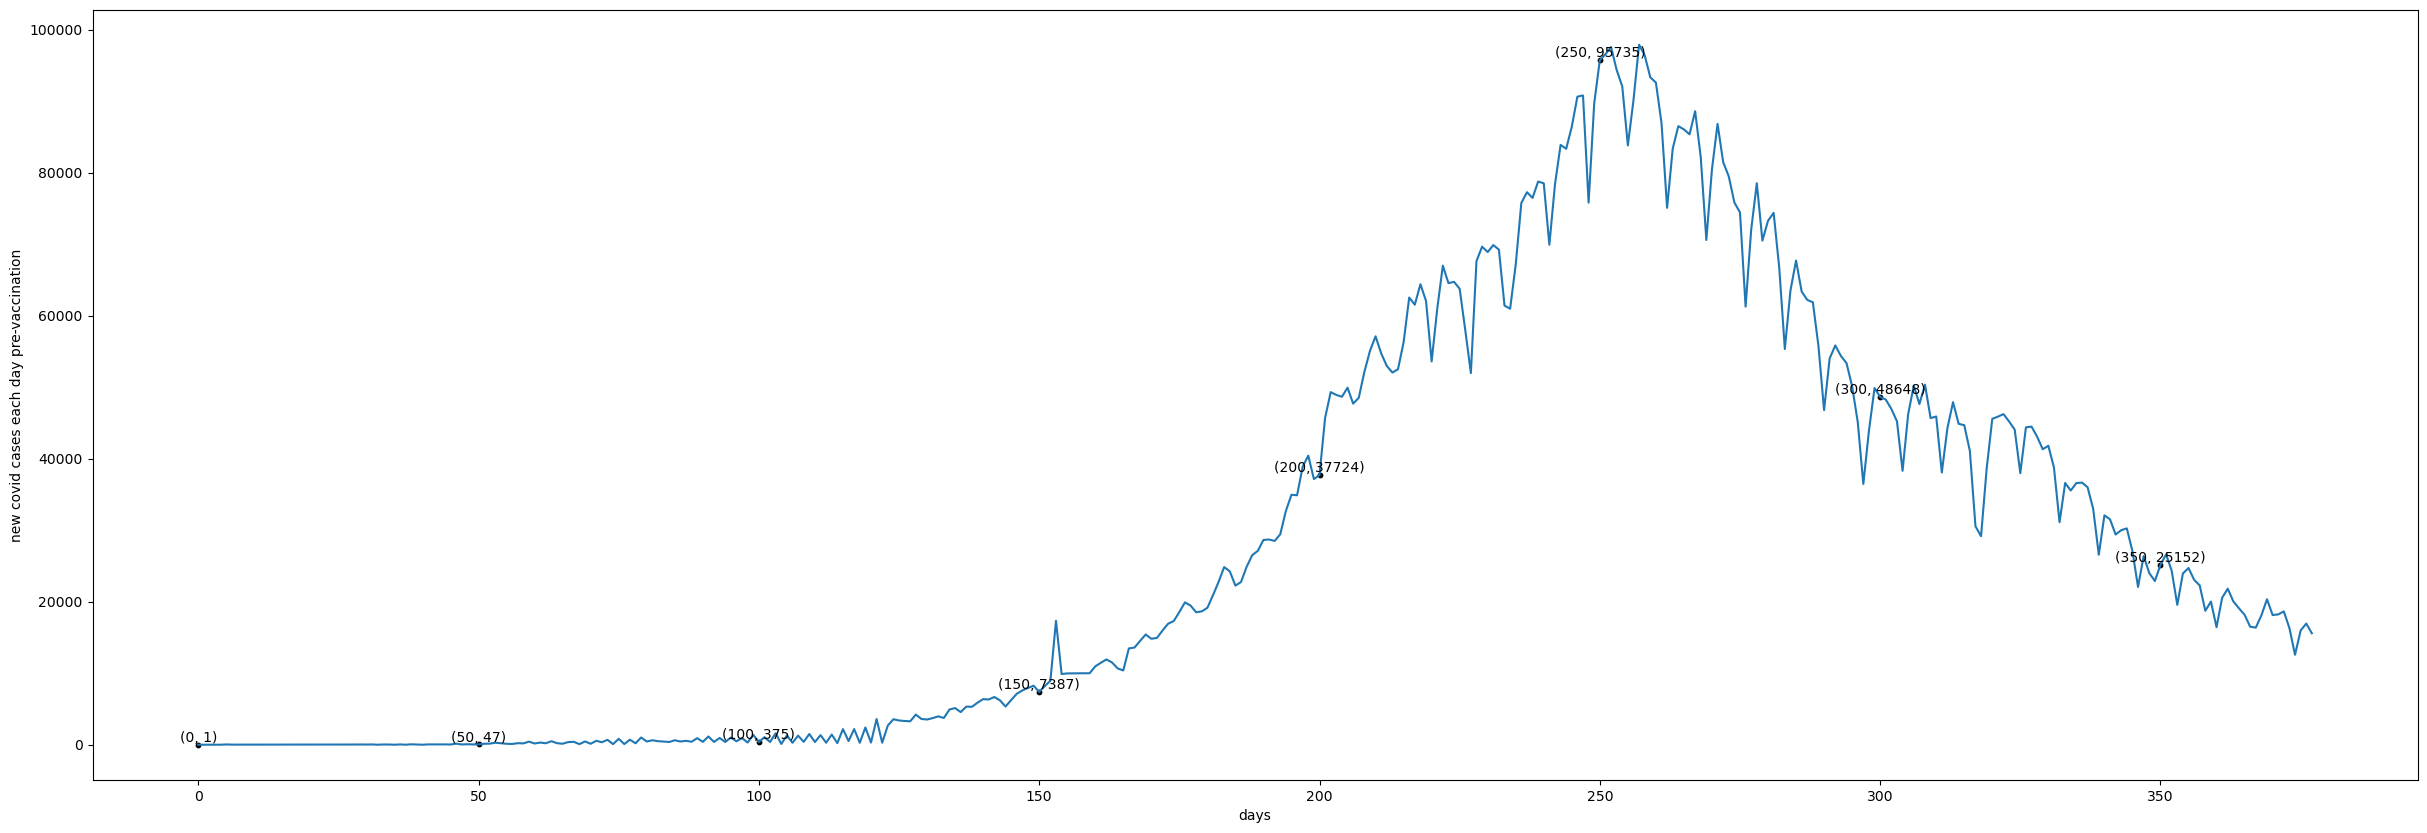

In [26]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("new covid cases each day pre-vaccination")
plt.plot(pre_vaccination_new)
plot_points(plt, pre_vaccination_new, 0, 50, 0, 0)

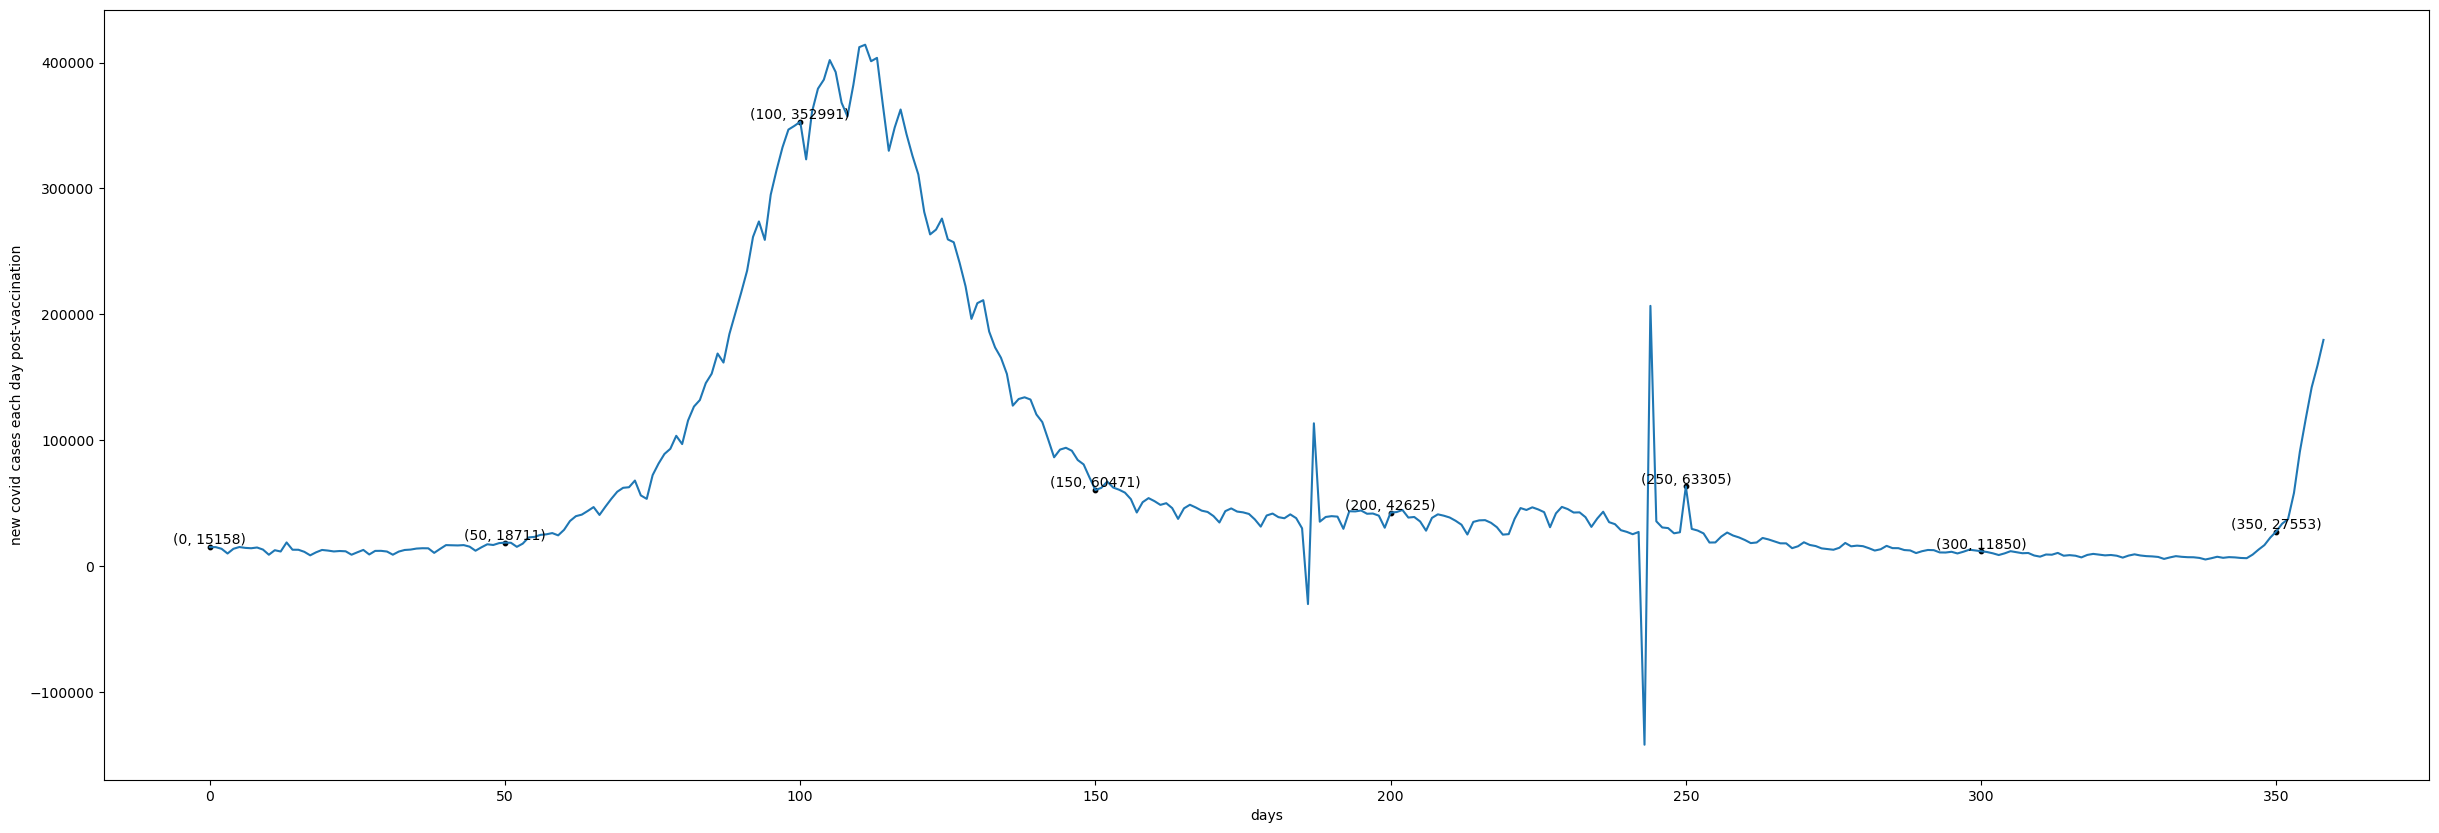

In [27]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("new covid cases each day post-vaccination")
plt.plot(post_vaccination_new)
plot_points(plt, post_vaccination_new, 0, 50, 0, 0)

**Comparison of Total and New cases side by side, pre and post vaccination**

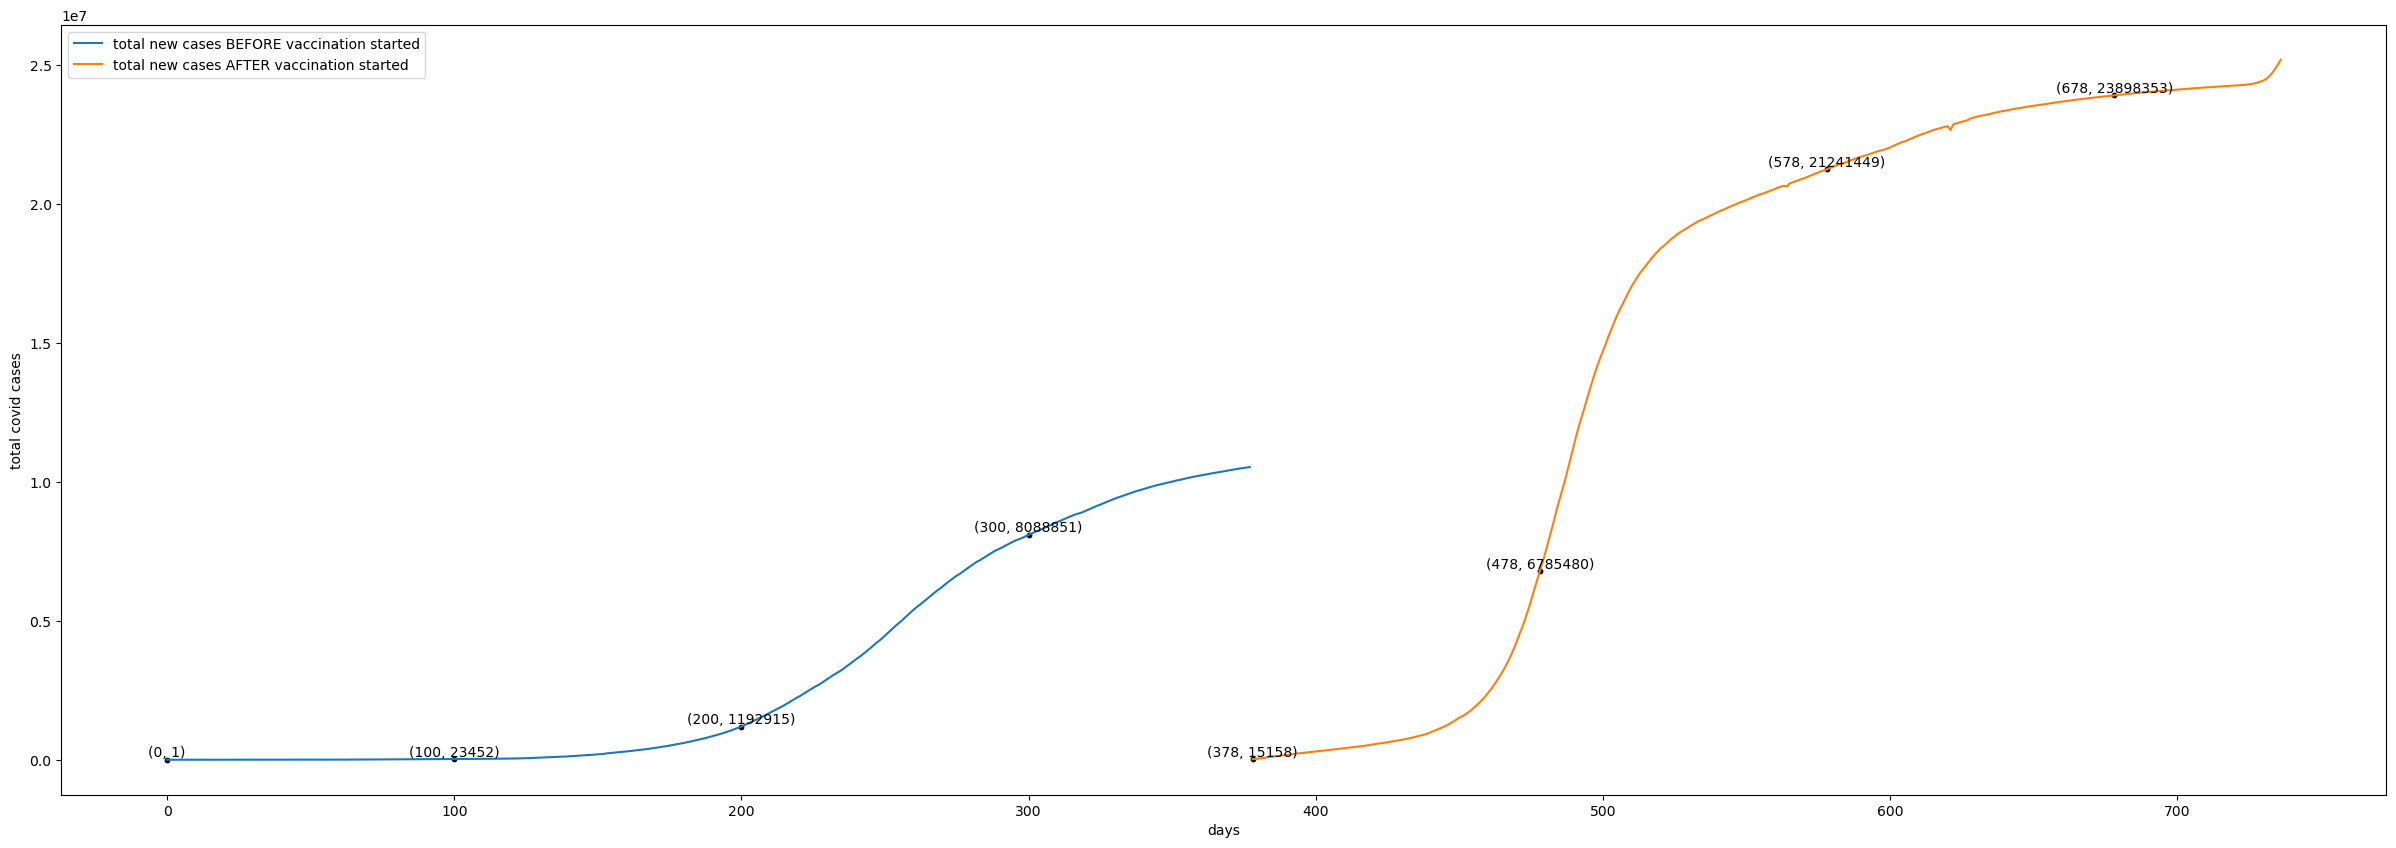

In [28]:
shift = len(pre_vaccination_total)

plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("total covid cases")
plt.plot(pre_vaccination_total, label='total new cases BEFORE vaccination started')
plt.plot(range(shift, shift+len(post_vaccination_total)), post_vaccination_total, label='total new cases AFTER vaccination started')
plt.legend()

plot_points(plt, pre_vaccination_total, 0, 100, 0, 0)
plot_points(plt, post_vaccination_total, shift, 100, 0, 0)

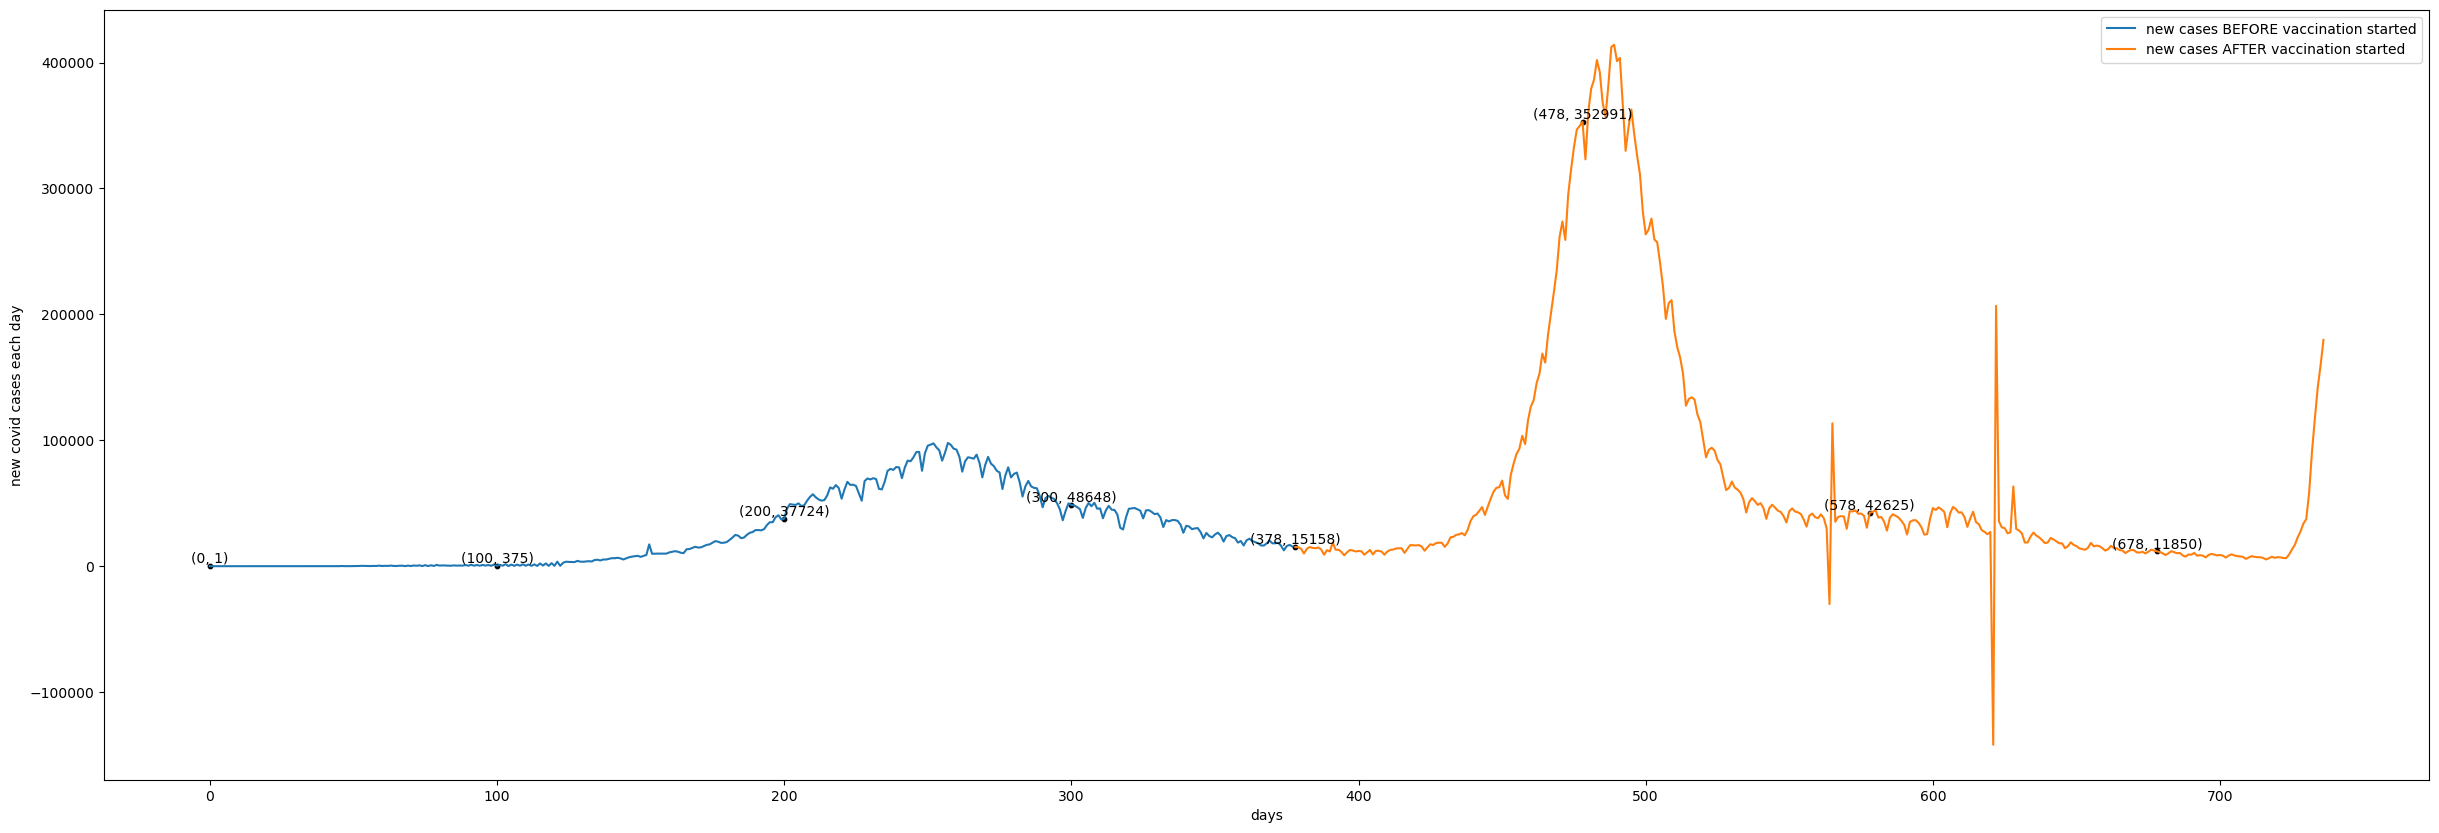

In [29]:
shift = len(pre_vaccination_new)

plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("new covid cases each day")
plt.plot(pre_vaccination_new, label='new cases BEFORE vaccination started')
plt.plot(range(shift, shift+len(post_vaccination_new)), post_vaccination_new, label='new cases AFTER vaccination started')
plt.legend()

plot_points(plt, pre_vaccination_new, 0, 100, 0, 0)
plot_points(plt, post_vaccination_new, shift, 100, 0, 0)

**Prediction by training model on data post vaccination**

In [30]:
E = 1000
callback = EarlyStopping(monitor='loss', mode='min', patience=20)
model = new_model()

size = len(pre_vaccination_total)
train_data = train_data[size:]
train_labels = train_labels[size:]
H = model.fit(train_data,train_labels,epochs=E, verbose=0, callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 250)               341000    
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 250)               62750     
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 90)                22590     
                                                                 
 dropout_5 (Dropout)         (None, 90)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

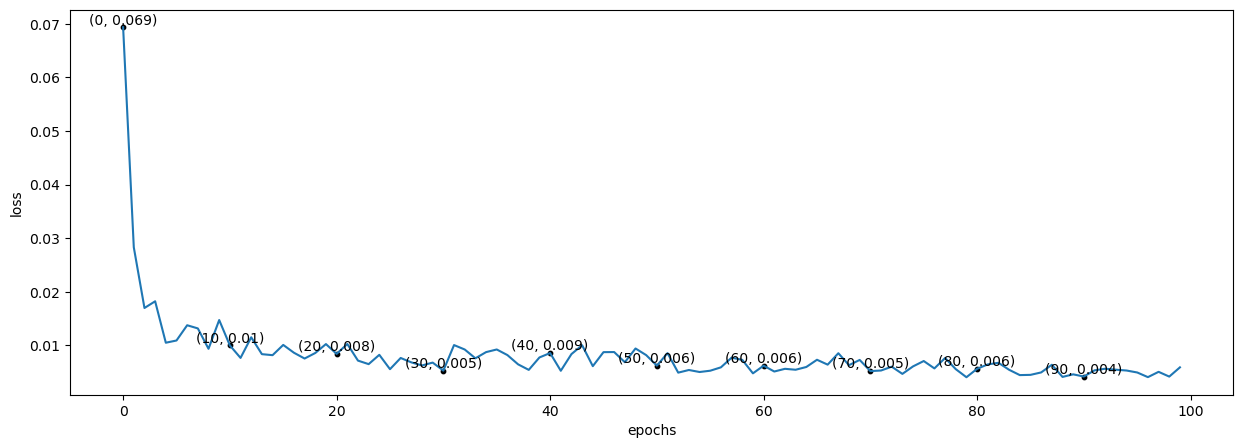

In [31]:
loss = H.history['loss']
epochs = range(0,len(loss))
plt.figure(figsize=(15,5))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(epochs,loss)
plot_points(plt, loss, 0, 10, 0, 3)

9/9 [==============================] - 1s 3ms/step


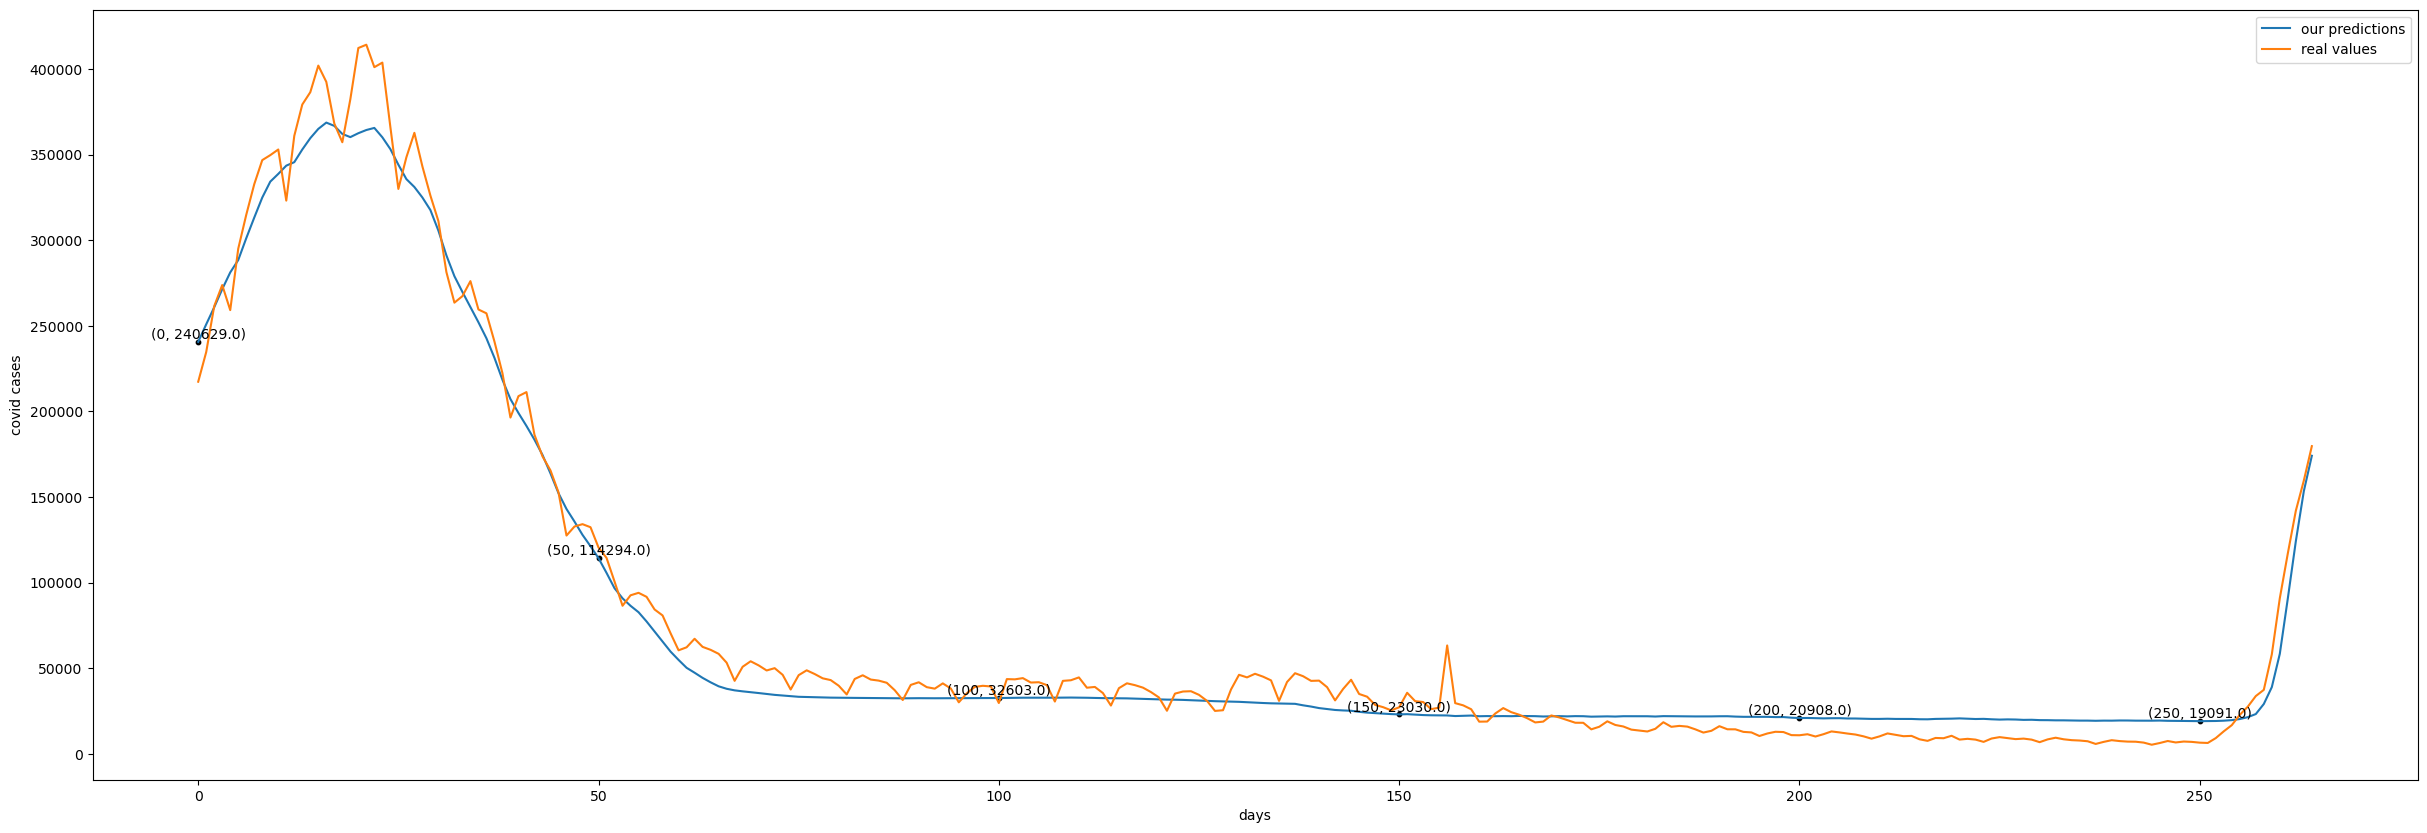

In [32]:
preds = scaler.inverse_transform(model.predict(train_data))
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases")
plt.plot(preds,label='our predictions')
plt.plot(scaler.inverse_transform(train_labels),label='real values')
plt.legend()
plot_points(plt, preds, 0, 50, 0, 0)

In [33]:
days_to_predict = 90
seed = array[-day:]
#seed

In [34]:
for _ in range(days_to_predict):
    current_days = seed[-day:]
    current_days = np.squeeze(current_days)
    current_days = np.expand_dims(current_days,0)
    current_days = np.expand_dims(current_days,0)
    pred = model.predict(current_days)
    seed = np.append(seed,pred)

#seed

1/1 [==============================] - 0s 26ms/step


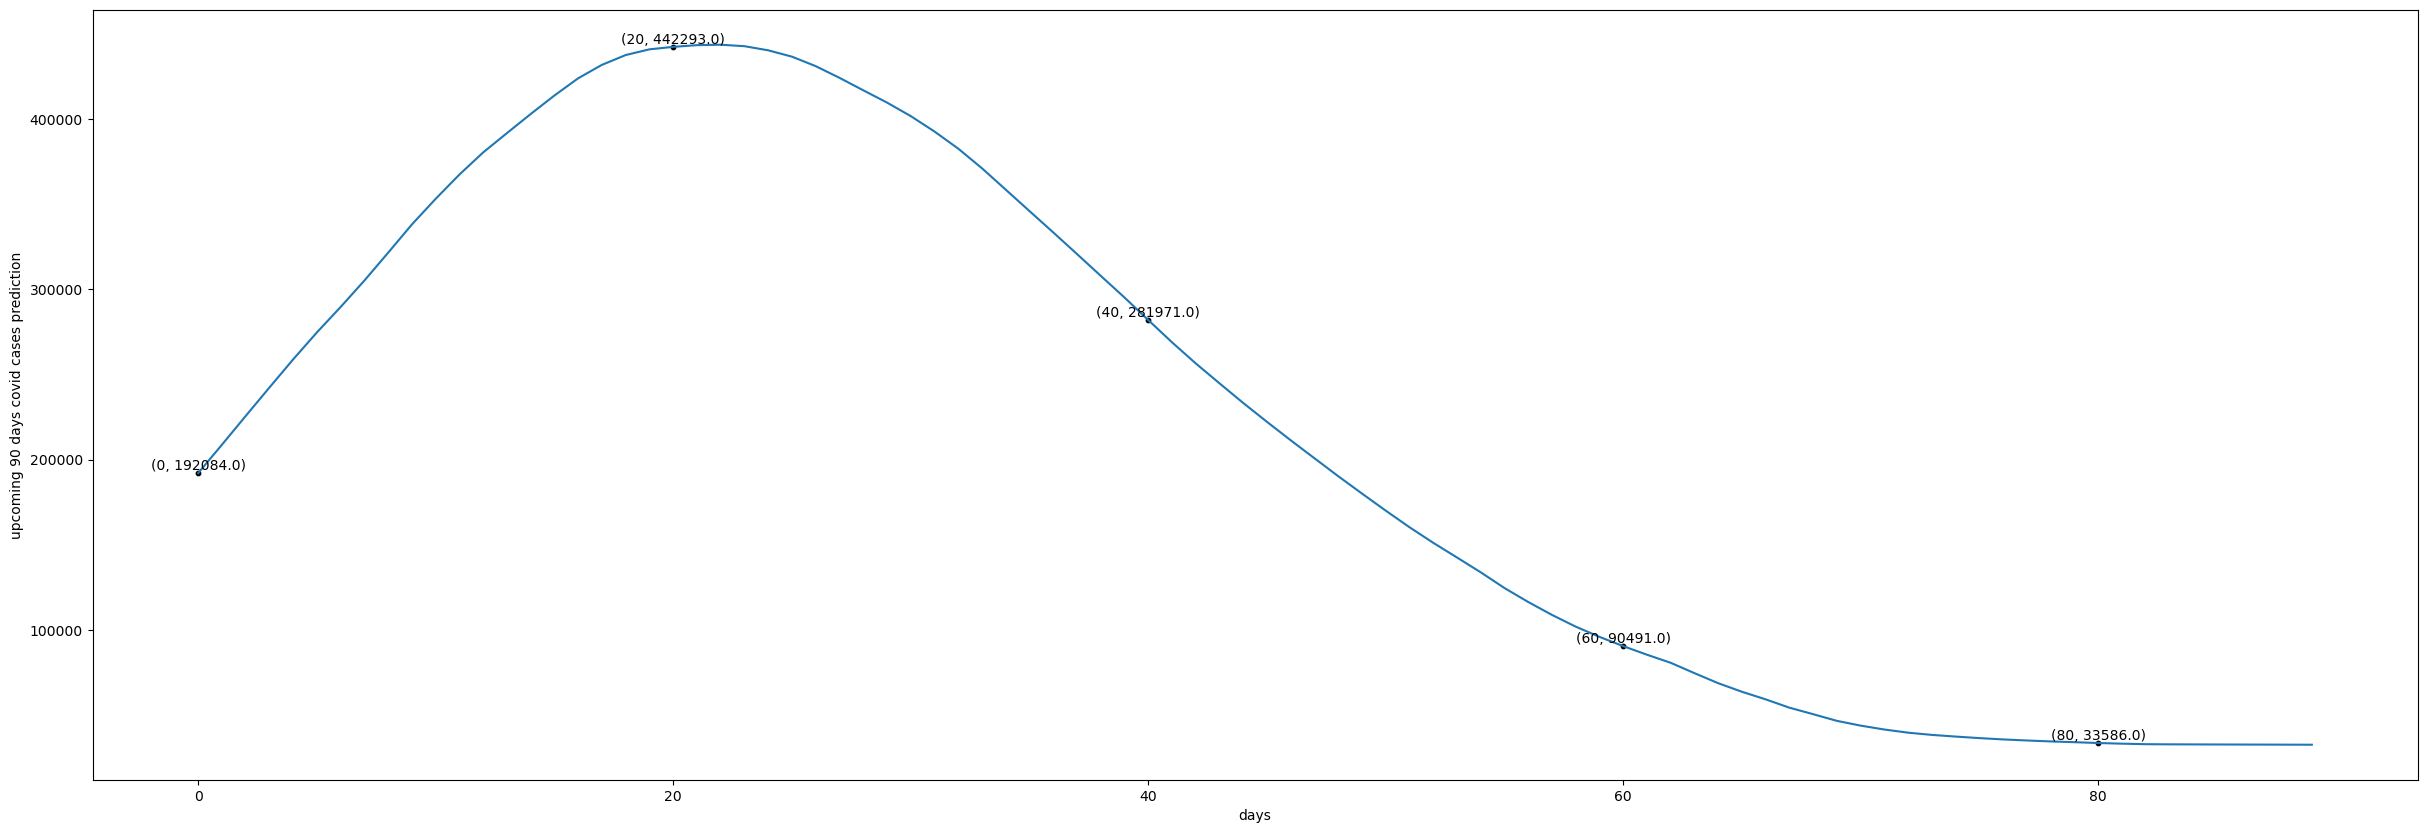

In [35]:
upcoming_days_prediction = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("upcoming " + str(days_to_predict) + " days covid cases prediction")
plt.plot(range(0,days_to_predict),upcoming_days_prediction)
plot_points(plt, upcoming_days_prediction, 0, 20, 0, 0)

In [36]:
# Adding real values and predicted values together
arr_without_pred = scaler.inverse_transform(train_labels)
arr_pred = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
arr_with_pred = np.concatenate((arr_without_pred, arr_pred))

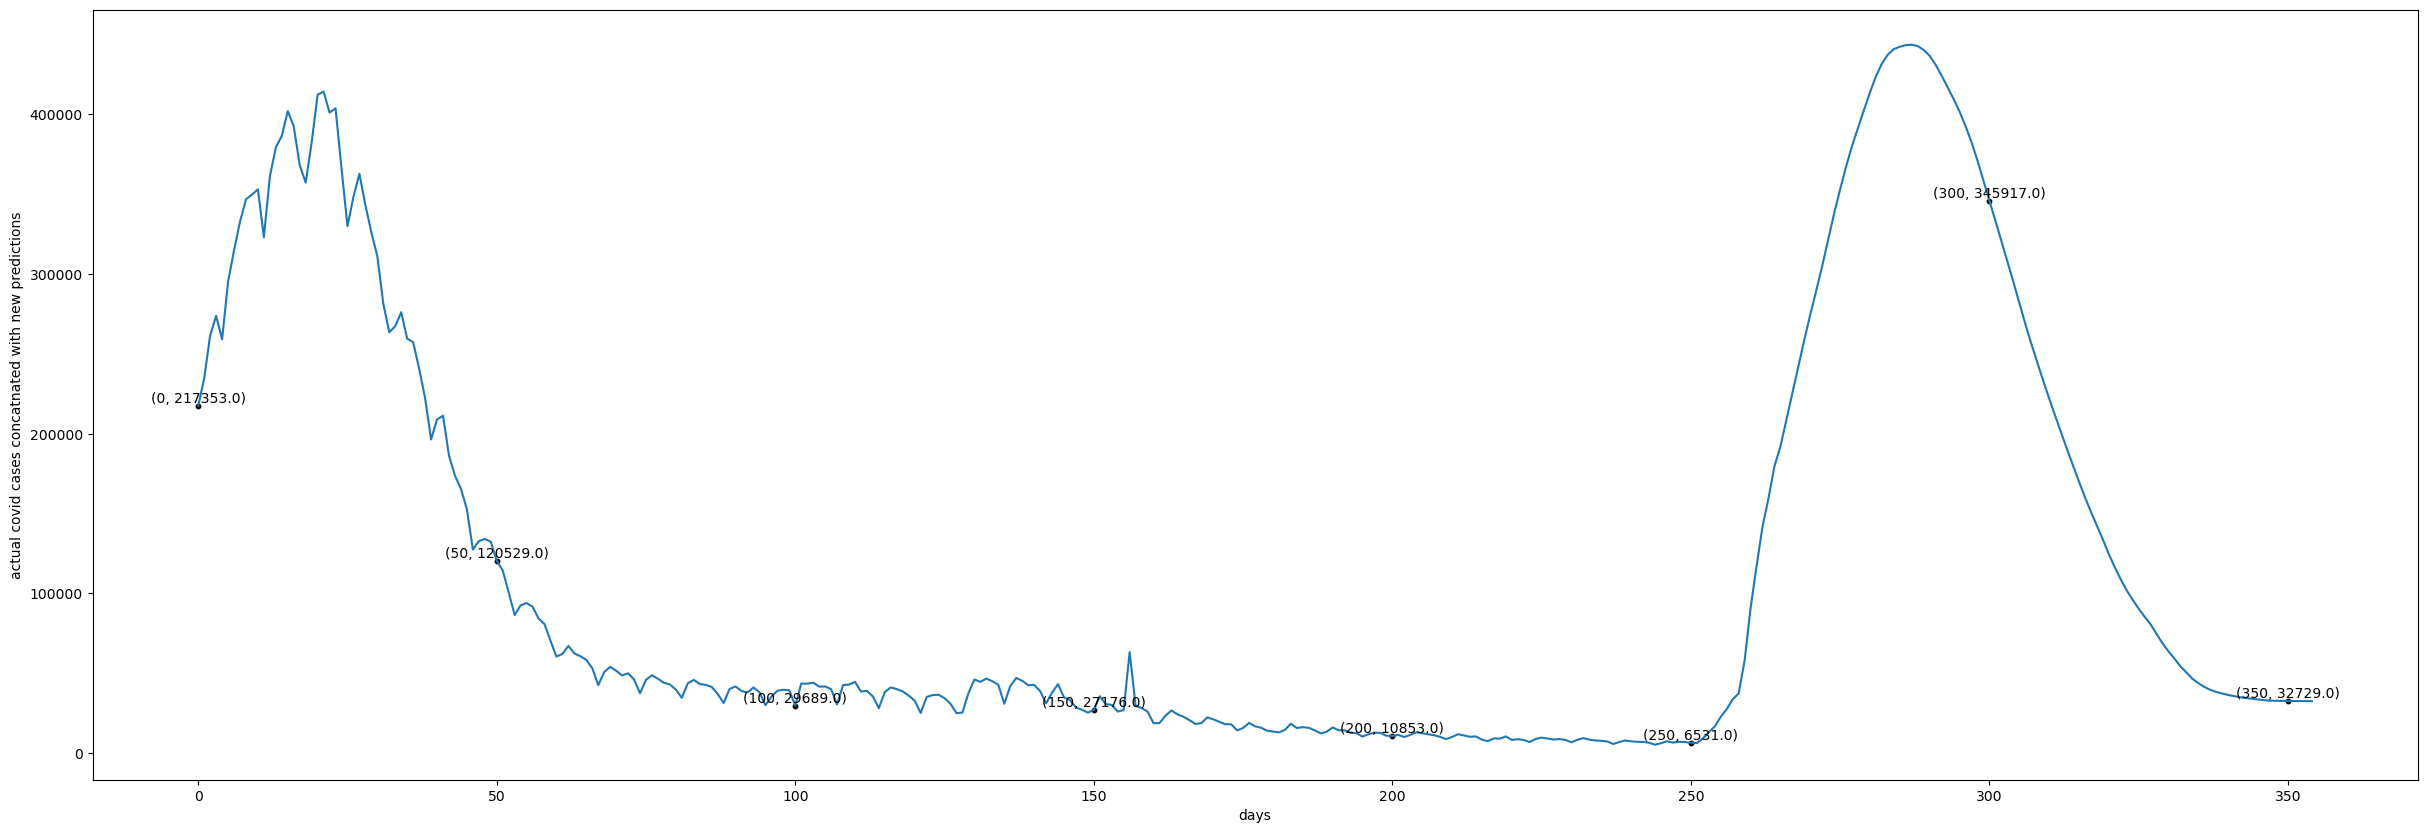

In [37]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("actual covid cases concatnated with new predictions")
plt.plot(arr_with_pred)
plot_points(plt, arr_with_pred, 0, 50, 0, 0)

In [38]:
total_new_cases = 0
for i in upcoming_days_prediction:
    total_new_cases += i[0]
    #print(i)
print(total_new_cases)

19514286.016317666


Random Forest Model

In [39]:
from sklearn.ensemble import RandomForestRegressor

# create a Random Forest model with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model to the training data
x, y, z = train_data.shape
rf_data = train_data.reshape((x, y*z))
rf_model.fit(rf_data, train_labels)

# make predictions on new data
rf_predictions = rf_model.predict(rf_data)
rf_predictions = rf_predictions.reshape((rf_predictions.shape[0], 1))
rf_predictions = scaler.inverse_transform(rf_predictions)

C:\Users\sanke\AppData\Local\Temp\ipykernel_11544\2345897101.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(rf_data, train_labels)


SVM Model

In [40]:
from sklearn.svm import SVR

svm_model = SVR(kernel='linear', C=100, gamma='auto')

# train the model
x, y, z = train_data.shape
svm_data = train_data.reshape((x, y*z))
svm_model.fit(svm_data, train_labels)

# predict on the test set
svm_predictions = svm_model.predict(svm_data)
svm_predictions = svm_predictions.reshape((svm_predictions.shape[0], 1))
svm_predictions = scaler.inverse_transform(svm_predictions)

C:\Users\sanke\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Comparing predictions of the 3 models(Sequential, Random Forest and SVM) with the original data


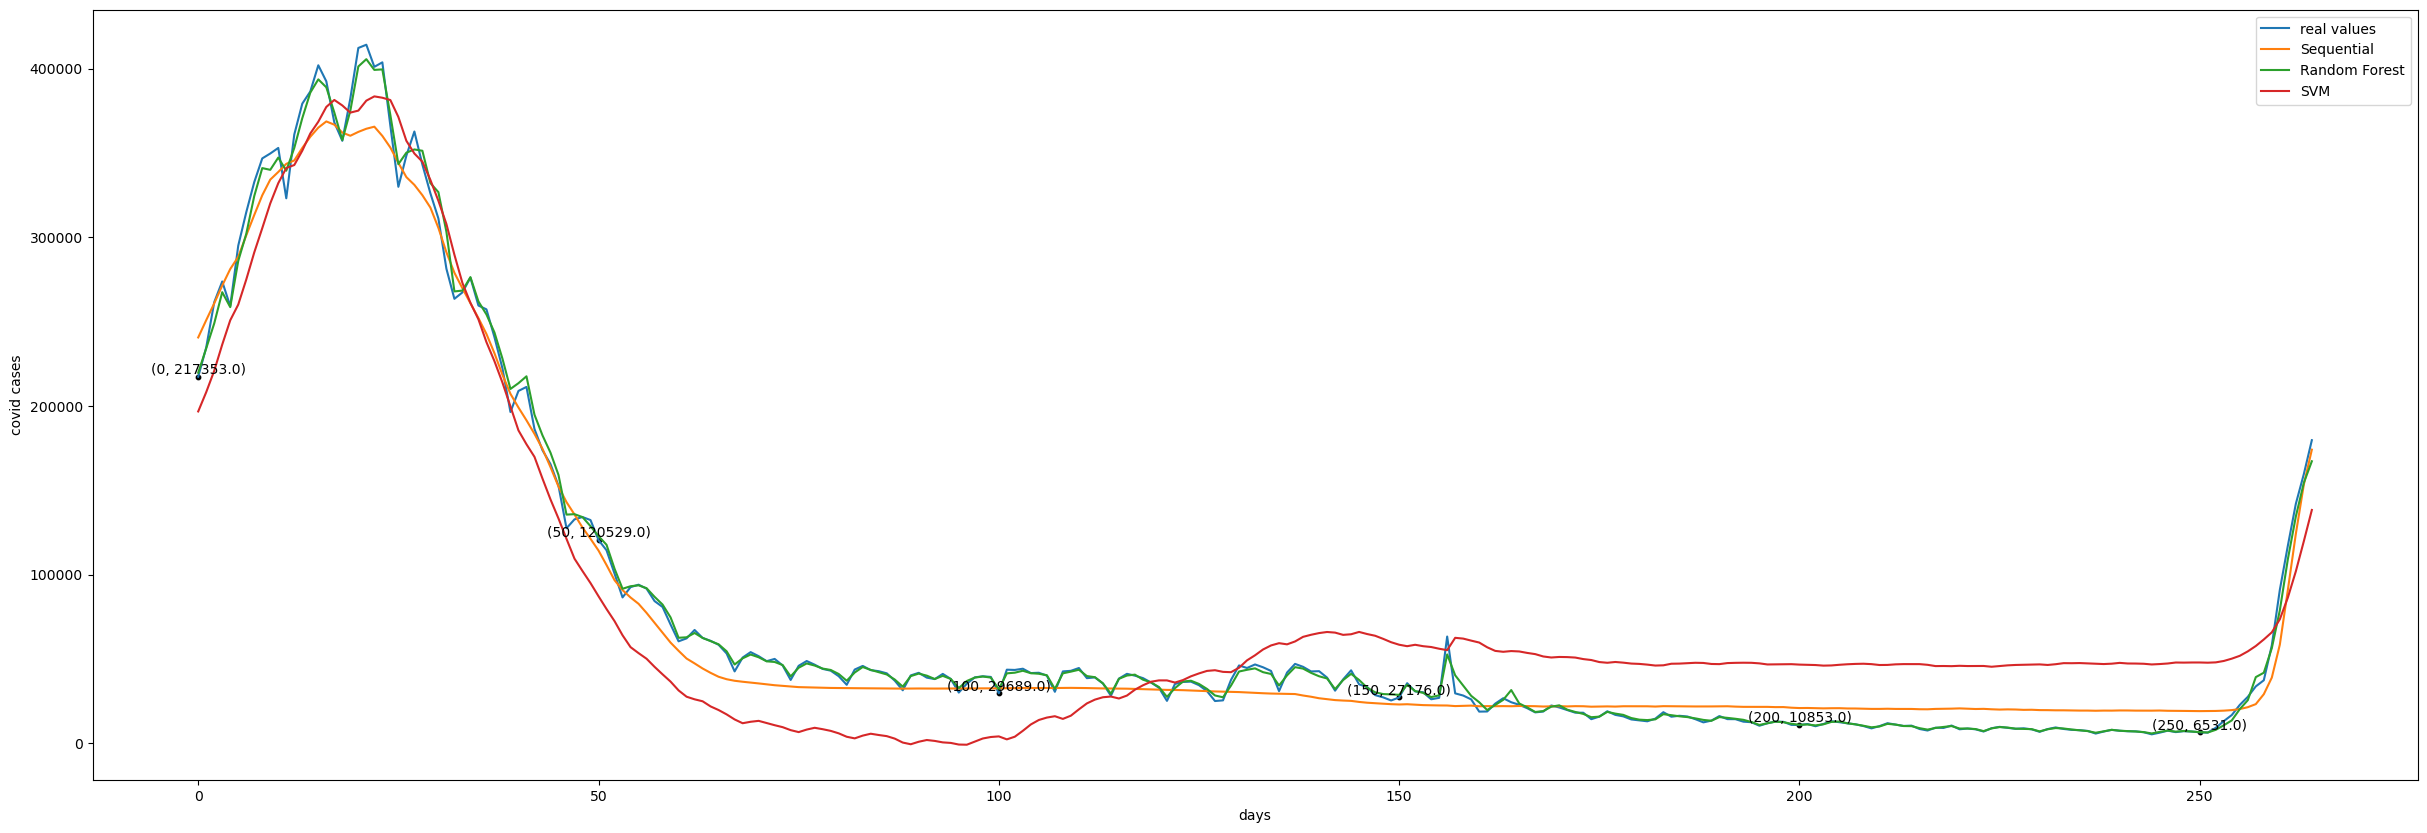

In [41]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases")
plt.plot(scaler.inverse_transform(train_labels), label='real values')
plt.plot(preds, label='Sequential')
plt.plot(rf_predictions, label='Random Forest')
plt.plot(svm_predictions, label='SVM')
plt.legend()
plot_points(plt, scaler.inverse_transform(train_labels), 0, 50, 0, 0)

Comparing accuracies

In [42]:
from sklearn.metrics import mean_absolute_error

seq_score = mean_absolute_error(preds, train_labels)
rf_score  = mean_absolute_error(rf_predictions, train_labels)
svm_score = mean_absolute_error(svm_predictions, train_labels)

print(seq_score, rf_score, svm_score)

78277.34 81233.1811794175 85666.95379150004


As we can see the MSE of sequential model is lowest, hence, it has the highest accuracy.

# Requirements of resources in the health sector:

1) Adequate funding: Sufficient financial resources are needed to support the development and maintenance of a robust health system.

2) Skilled health workforce: A well-trained and motivated workforce is essential to provide quality health services.

3) Medical equipment and supplies: Medical equipment such as ventilators, oxygen concentrators, and personal protective equipment (PPE) are needed to diagnose and treat illnesses.

4) Medicines and vaccines: Essential medicines and vaccines are required to prevent and treat illnesses.

5) Health infrastructure: Hospitals, clinics, and health centers are needed to provide health services.

6) Health information systems: Accurate and timely health information is needed to monitor health status and support health system decision-making.

7) Health research and development: Ongoing research is needed to identify new treatments, vaccines, and diagnostic tools.

8) Health promotion and disease prevention: Health education programs and initiatives are needed to promote healthy lifestyles and prevent illnesses.

9) Mental health services: Mental health services are required to address the growing burden of mental illness.

10) Maternal and child health services: Maternal and child health services are needed to promote healthy pregnancies and ensure healthy child development.

11) Emergency medical services: Emergency medical services are required to provide timely and appropriate care in emergency situations.

12) Rehabilitation services: Rehabilitation services are needed to help individuals recover from illness or injury.

13) Health financing: Effective health financing systems are needed to ensure that health services are accessible and affordable to all.

14) Health governance and leadership: Strong governance and leadership are essential to ensure effective and efficient health service delivery.

15) Health technology: Health technology can improve the quality and efficiency of health services.

16) Health regulation: Health regulation is needed to ensure the safety and quality of health services and products.

17) Health partnerships and collaboration: Collaboration and partnerships with other sectors and stakeholders can help to address health challenges.

18) Community participation: Community participation is needed to promote ownership and sustainability of health programs.

19) Health monitoring and evaluation: Monitoring and evaluation systems are needed to assess the effectiveness and impact of health programs.

20) Health policy and planning: Evidence-based policies and plans are needed to guide health system development and improve health outcomes.

# New beds required all over the country

In [43]:
total_beds = 191201
data_path = 'all_total.json'
f = open(data_path)
data = json.load(f)

active_cases = []
for row in data["rows"]:
  if "active_cases" in row["key"]:
    active_cases.append(row['value'])

bed_req = []
for cases in active_cases:
  bed_req.append(max(0, cases - total_beds))

Text(492, 3554036, '(492, 3554036)')

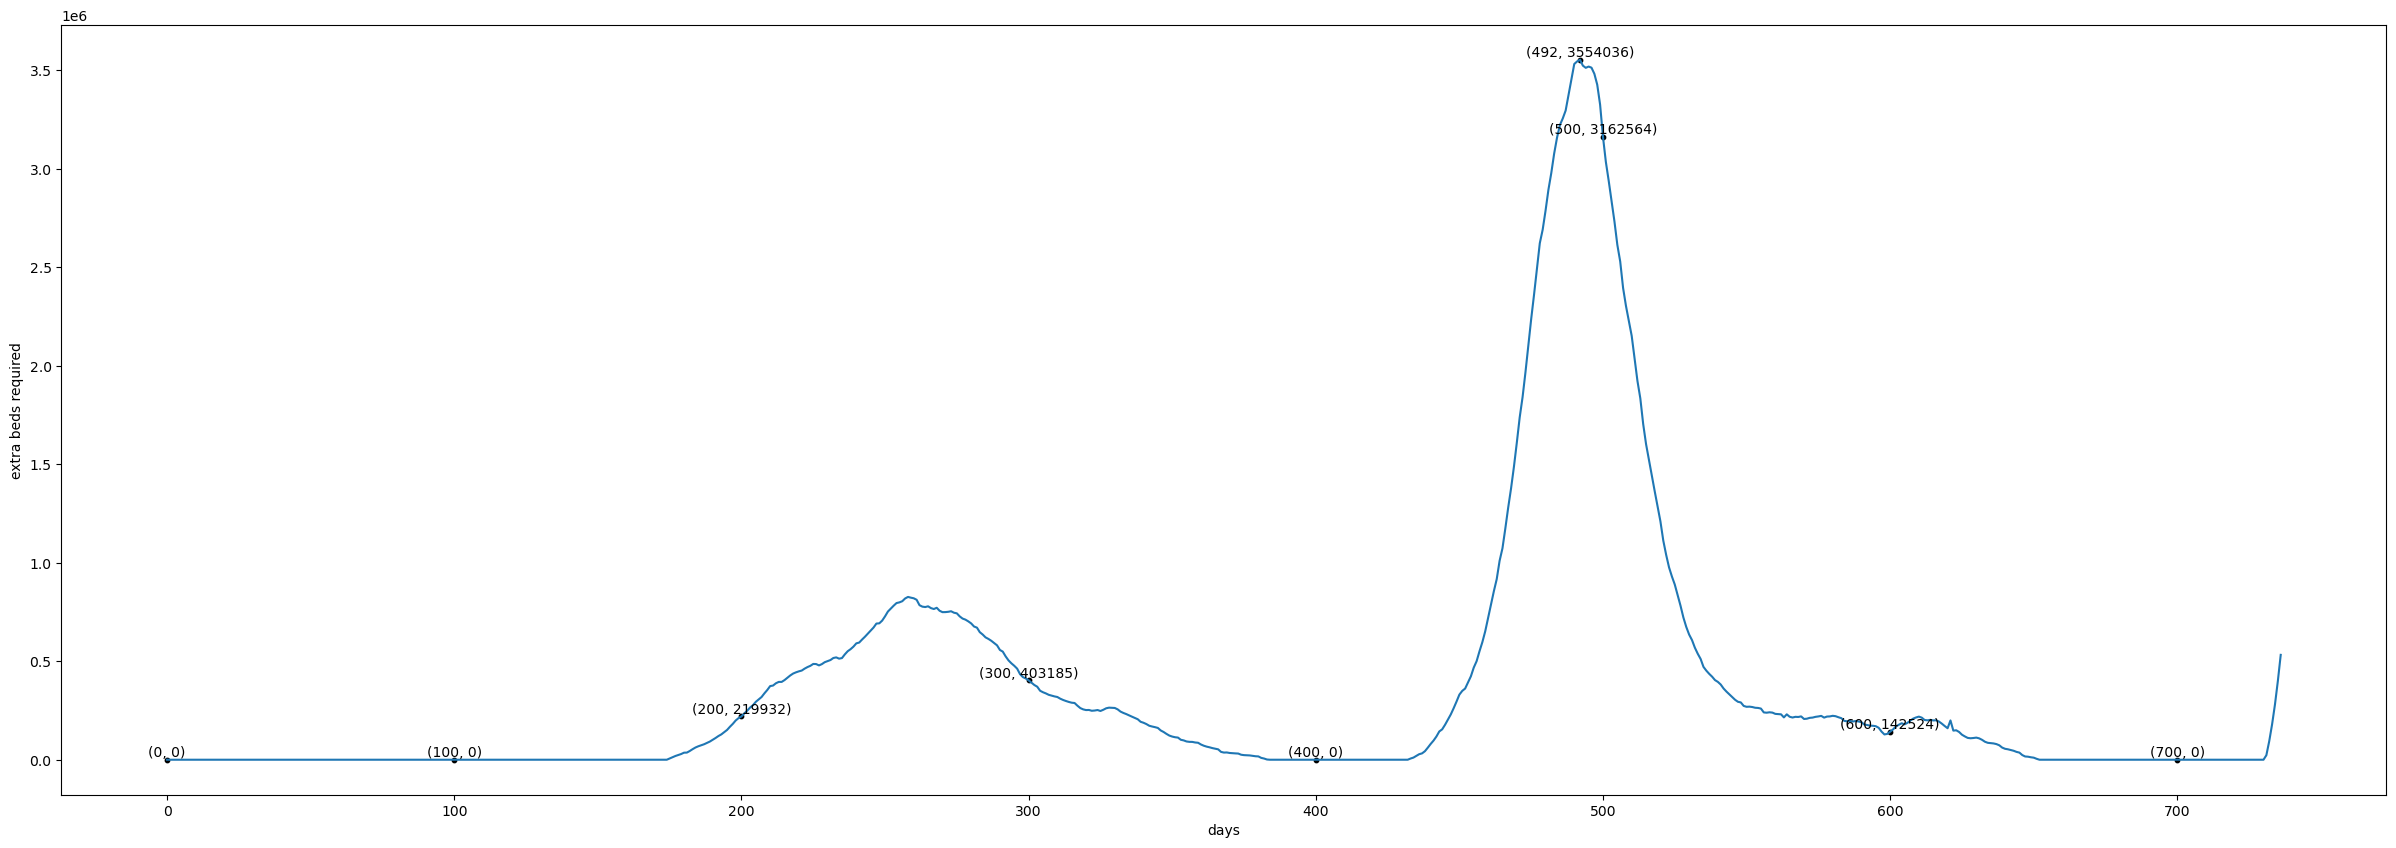

In [44]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("extra beds required")
plt.plot(bed_req)
plot_points(plt, bed_req, 0, 100, 0, 0)

# Maxima
y_max = np.max(bed_req)
x_max = np.where(bed_req == y_max)[0][0]
plt.scatter(x_max, y_max, color='black', s=10)
plt.text(x_max, y_max, f'({x_max:.0f}, {y_max:.0f})', ha='center', va='bottom')

# Prediction of the disease spread risk with high range of accuracy throughout the country


In [45]:
df_state = pd.read_csv("StatewiseTestingDetails.csv")
df_covid = pd.read_csv("covid_19_india.csv")
df_vacc  = pd.read_csv("covid_vaccine_statewise.csv")

In [46]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16336 entries, 0 to 16335
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          16336 non-null  object 
 1   State         16336 non-null  object 
 2   TotalSamples  16336 non-null  float64
 3   Negative      6969 non-null   object 
 4   Positive      5662 non-null   float64
dtypes: float64(2), object(3)
memory usage: 638.2+ KB


In [47]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [48]:
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Updated On                           7845 non-null   object 
 1   State                                7845 non-null   object 
 2   Total Doses Administered             7621 non-null   float64
 3   Sessions                             7621 non-null   float64
 4    Sites                               7621 non-null   float64
 5   First Dose Administered              7621 non-null   float64
 6   Second Dose Administered             7621 non-null   float64
 7   Male (Doses Administered)            7461 non-null   float64
 8   Female (Doses Administered)          7461 non-null   float64
 9   Transgender (Doses Administered)     7461 non-null   float64
 10   Covaxin (Doses Administered)        7621 non-null   float64
 11  CoviShield (Doses Administered

In [49]:
df_state['State'].unique(), df_state['State'].nunique()

(array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
        'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
        'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu',
        'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
        'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
        'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
        'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
        'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
        'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
       dtype=object),
 36)

In [50]:
df_vacc['State'].unique(), df_vacc['State'].nunique()

(array(['India', 'Andaman and Nicobar Islands', 'Andhra Pradesh',
        'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
        'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu',
        'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
        'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
        'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
        'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
        'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
        'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
       dtype=object),
 37)

In [51]:
df_covid['State/UnionTerritory'].unique(), df_covid['State/UnionTerritory'].nunique()

(array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
        'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
        'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
        'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
        'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
        'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
        'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
        'Tripura', 'Nagaland', 'Meghalaya',
        'Dadra and Nagar Haveli and Daman and Diu',
        'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
        'Lakshadweep', 'Telangana', 'Dadra and Nagar Haveli', 'Bihar****',
        'Madhya Pradesh***', 'Himanchal Pradesh', 'Karanataka',
        'Maharashtra***'], dtype=object),
 46)

In [52]:
dict(zip(df_vacc['State'].unique(), df_vacc['State'].unique()))

{'India': 'India',
 'Andaman and Nicobar Islands': 'Andaman and Nicobar Islands',
 'Andhra Pradesh': 'Andhra Pradesh',
 'Arunachal Pradesh': 'Arunachal Pradesh',
 'Assam': 'Assam',
 'Bihar': 'Bihar',
 'Chandigarh': 'Chandigarh',
 'Chhattisgarh': 'Chhattisgarh',
 'Dadra and Nagar Haveli and Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',
 'Delhi': 'Delhi',
 'Goa': 'Goa',
 'Gujarat': 'Gujarat',
 'Haryana': 'Haryana',
 'Himachal Pradesh': 'Himachal Pradesh',
 'Jammu and Kashmir': 'Jammu and Kashmir',
 'Jharkhand': 'Jharkhand',
 'Karnataka': 'Karnataka',
 'Kerala': 'Kerala',
 'Ladakh': 'Ladakh',
 'Lakshadweep': 'Lakshadweep',
 'Madhya Pradesh': 'Madhya Pradesh',
 'Maharashtra': 'Maharashtra',
 'Manipur': 'Manipur',
 'Meghalaya': 'Meghalaya',
 'Mizoram': 'Mizoram',
 'Nagaland': 'Nagaland',
 'Odisha': 'Odisha',
 'Puducherry': 'Puducherry',
 'Punjab': 'Punjab',
 'Rajasthan': 'Rajasthan',
 'Sikkim': 'Sikkim',
 'Tamil Nadu': 'Tamil Nadu',
 'Telangana': 'Telangana',
 'Tripura': 'Trip

In [53]:
df_covid['State/UnionTerritory'].unique(), df_covid['State/UnionTerritory'].nunique()

(array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
        'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
        'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
        'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
        'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
        'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
        'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
        'Tripura', 'Nagaland', 'Meghalaya',
        'Dadra and Nagar Haveli and Daman and Diu',
        'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
        'Lakshadweep', 'Telangana', 'Dadra and Nagar Haveli', 'Bihar****',
        'Madhya Pradesh***', 'Himanchal Pradesh', 'Karanataka',
        'Maharashtra***'], dtype=object),
 46)

In [54]:
state_correction_dict = {
  'Bihar****': 'Bihar',
  'Dadra and Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
  'Madhya Pradesh***': 'Madhya Pradesh',
  'Maharashtra***': 'Maharashtra',
}

In [55]:
def state_correction(state):
  try:
    return state_correction_dict[state]
  except:
    return state

In [56]:
df_covid['State/UnionTerritory'] = df_covid['State/UnionTerritory'].apply(state_correction)

In [57]:
df_vacc['Updated On'] = pd.to_datetime(df_vacc['Updated On'])
df_state['Date'] = pd.to_datetime(df_state['Date'])
df_covid['Date'] = pd.to_datetime(df_covid['Date'])

C:\Users\sanke\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sanke\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '17/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sanke\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '18/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sanke\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '19/01/2021' in DD/MM/YYYY format. Provide format or specif

In [58]:
df_state.columns, df_state.shape

(Index(['Date', 'State', 'TotalSamples', 'Negative', 'Positive'], dtype='object'),
 (16336, 5))

In [59]:
df_covid.columns, df_covid.shape

(Index(['Sno', 'Date', 'Time', 'State/UnionTerritory',
        'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured',
        'Deaths', 'Confirmed'],
       dtype='object'),
 (18110, 9))

In [60]:
df = df_covid.merge(df_state, left_on = ["State/UnionTerritory","Date"], right_on=["State","Date"], how='left')

# Information about the DataSet

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18111 entries, 0 to 18110
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18111 non-null  int64         
 1   Date                      18111 non-null  datetime64[ns]
 2   Time                      18111 non-null  object        
 3   State/UnionTerritory      18111 non-null  object        
 4   ConfirmedIndianNational   18111 non-null  object        
 5   ConfirmedForeignNational  18111 non-null  object        
 6   Cured                     18111 non-null  int64         
 7   Deaths                    18111 non-null  int64         
 8   Confirmed                 18111 non-null  int64         
 9   State                     15943 non-null  object        
 10  TotalSamples              15943 non-null  float64       
 11  Negative                  6865 non-null   object        
 12  Positive          

Null Values in the DataSet

In [62]:
df.isna().sum()

Sno                             0
Date                            0
Time                            0
State/UnionTerritory            0
ConfirmedIndianNational         0
ConfirmedForeignNational        0
Cured                           0
Deaths                          0
Confirmed                       0
State                        2168
TotalSamples                 2168
Negative                    11246
Positive                    12596
dtype: int64

In [63]:
df.drop(columns=["ConfirmedIndianNational","ConfirmedForeignNational",'Sno',"Time"],inplace=True)
df.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed State  \
0 2020-01-30               Kerala      0       0          1   NaN   
1 2020-01-31               Kerala      0       0          1   NaN   
2 2020-02-01               Kerala      0       0          2   NaN   
3 2020-02-02               Kerala      0       0          3   NaN   
4 2020-02-03               Kerala      0       0          3   NaN   

   TotalSamples Negative  Positive  
0           NaN      NaN       NaN  
1           NaN      NaN       NaN  
2           NaN      NaN       NaN  
3           NaN      NaN       NaN  
4           NaN      NaN       NaN

In [64]:
df.fillna(0,inplace=True)
df.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed State  \
0 2020-01-30               Kerala      0       0          1     0   
1 2020-01-31               Kerala      0       0          1     0   
2 2020-02-01               Kerala      0       0          2     0   
3 2020-02-02               Kerala      0       0          3     0   
4 2020-02-03               Kerala      0       0          3     0   

   TotalSamples Negative  Positive  
0           0.0        0       0.0  
1           0.0        0       0.0  
2           0.0        0       0.0  
3           0.0        0       0.0  
4           0.0        0       0.0

In [65]:
df.describe()

Cured         Deaths     Confirmed  TotalSamples      Positive
count  1.811100e+04   18111.000000  1.811100e+04  1.811100e+04  1.811100e+04
mean   2.786221e+05    4052.178621  3.010148e+05  4.757145e+06  1.745889e+04
std    6.148774e+05   10918.816423  6.561346e+05  8.496938e+06  9.709808e+04
min    0.000000e+00       0.000000  0.000000e+00  0.000000e+00  0.000000e+00
25%    3.358500e+03      32.000000  4.376000e+03  6.240150e+04  0.000000e+00
50%    3.335800e+04     588.000000  3.977000e+04  5.603400e+05  0.000000e+00
75%    2.788595e+05    3643.500000  3.001465e+05  6.074854e+06  2.450000e+02
max    6.159676e+06  134201.000000  6.363442e+06  6.789786e+07  1.638961e+06

In [66]:
df["TotalSamples"]=df["TotalSamples"].astype(int)

In [67]:
df["Day"]=pd.to_datetime(df["Date"]).dt.day
df["Month"]=pd.to_datetime(df["Date"]).dt.month
df["Year"]=pd.to_datetime(df["Date"]).dt.year
df.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed State  \
0 2020-01-30               Kerala      0       0          1     0   
1 2020-01-31               Kerala      0       0          1     0   
2 2020-02-01               Kerala      0       0          2     0   
3 2020-02-02               Kerala      0       0          3     0   
4 2020-02-03               Kerala      0       0          3     0   

   TotalSamples Negative  Positive  Day  Month  Year  
0             0        0       0.0   30      1  2020  
1             0        0       0.0   31      1  2020  
2             0        0       0.0    1      2  2020  
3             0        0       0.0    2      2  2020  
4             0        0       0.0    3      2  2020

In [68]:
num_cols=df.select_dtypes(exclude=['object']).columns
num_cols

Index(['Date', 'Cured', 'Deaths', 'Confirmed', 'TotalSamples', 'Positive',
       'Day', 'Month', 'Year'],
      dtype='object')

In [69]:
str_cols=df.select_dtypes(exclude=['float','int']).columns
str_cols

Index(['Date', 'State/UnionTerritory', 'State', 'Negative'], dtype='object')

In [70]:
for col in num_cols:
    print("Column : ", col)
    print(f"Value counts of {col}: ",df[col].value_counts().sum())
    print(f"Number of Unique Values in {col}: ",df[col].nunique())
    print()

Column :  Date
Value counts of Date:  18111
Number of Unique Values in Date:  560

Column :  Cured
Value counts of Cured:  18111
Number of Unique Values in Cured:  14445

Column :  Deaths
Value counts of Deaths:  18111
Number of Unique Values in Deaths:  6471

Column :  Confirmed
Value counts of Confirmed:  18111
Number of Unique Values in Confirmed:  14971

Column :  TotalSamples
Value counts of TotalSamples:  18111
Number of Unique Values in TotalSamples:  15807

Column :  Positive
Value counts of Positive:  18111
Number of Unique Values in Positive:  4258

Column :  Day
Value counts of Day:  18111
Number of Unique Values in Day:  31

Column :  Month
Value counts of Month:  18111
Number of Unique Values in Month:  12

Column :  Year
Value counts of Year:  18111
Number of Unique Values in Year:  2



In [71]:
for cols in str_cols:
    print("Column : ", cols)
    print(f"Value counts of {cols}: ",df[cols].value_counts().sum())
    print(f"Number of Unique Values in {cols}: ",df[cols].nunique())
    print()

Column :  Date
Value counts of Date:  18111
Number of Unique Values in Date:  560

Column :  State/UnionTerritory
Value counts of State/UnionTerritory:  18111
Number of Unique Values in State/UnionTerritory:  42

Column :  State
Value counts of State:  18111
Number of Unique Values in State:  37

Column :  Negative
Value counts of Negative:  18111
Number of Unique Values in Negative:  6806



In [72]:
state_cases = df.groupby(['State/UnionTerritory'])['Confirmed','Deaths','Cured'].max().reset_index()
state_cases

C:\Users\sanke\AppData\Local\Temp\ipykernel_11544\2433636184.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  state_cases = df.groupby(['State/UnionTerritory'])['Confirmed','Deaths','Cured'].max().reset_index()


State/UnionTerritory  Confirmed  Deaths    Cured
0                Andaman and Nicobar Islands       7548     129     7412
1                             Andhra Pradesh    1985182   13564  1952736
2                          Arunachal Pradesh      50605     248    47821
3                                      Assam     576149    5420   559684
4                                      Bihar     725279    9646   715352
5           Cases being reassigned to states       9265       0        0
6                                 Chandigarh      61992     811    61150
7                               Chhattisgarh    1003356   13544   988189
8   Dadra and Nagar Haveli and Daman and Diu      10654       4    10646
9                                Daman & Diu          2       0        0
10                                     Delhi    1436852   25068  1411280
11                                       Goa     172085    3164   167978
12                                   Gujarat     825085   10077   814802
13                                   Haryana     770114    9652   759790
14                          Himachal Pradesh     208616    3537   202761
15                         Himanchal Pradesh     204516    3507   200040
16                         Jammu and Kashmir     322771    4392   317081
17                                 Jharkhand     347440    5130   342102
18                                Karanataka    2885238   36197  2821491
19                                 Karnataka    2921049   36848  2861499
20                                    Kerala    3586693   18004  3396184
21                                    Ladakh      20411     207    20130
22                               Lakshadweep      10263      51    10165
23                            Madhya Pradesh     791980   10514   781330
24                               Maharashtra    6363442  134201  6159676
25                                   Manipur     105424    1664    96776
26                                 Meghalaya      69769    1185    64157
27                                   Mizoram      46320     171    33722
28                                  Nagaland      28811     585    26852
29                                    Odisha     988997    6565   972710
30                                Puducherry     121766    1800   119115
31                                    Punjab     599573   16322   582791
32                                 Rajasthan     953851    8954   944700
33                                    Sikkim      28018     356    25095
34                                Tamil Nadu    2579130   34367  2524400
35                                 Telangana     650353    3831   638410
36                                 Telengana     443360    2312   362160
37                                   Tripura      80660     773    77811
38                                Unassigned         77       0        0
39                             Uttar Pradesh    1708812   22775  1685492
40                               Uttarakhand     342462    7368   334650
41                               West Bengal    1534999   18252  1506532

In [73]:
state_cases['Active'] = state_cases['Confirmed'] - abs((state_cases['Deaths']- state_cases['Cured']))
state_cases.tail()

State/UnionTerritory  Confirmed  Deaths    Cured  Active
37              Tripura      80660     773    77811    3622
38           Unassigned         77       0        0      77
39        Uttar Pradesh    1708812   22775  1685492   46095
40          Uttarakhand     342462    7368   334650   15180
41          West Bengal    1534999   18252  1506532   46719

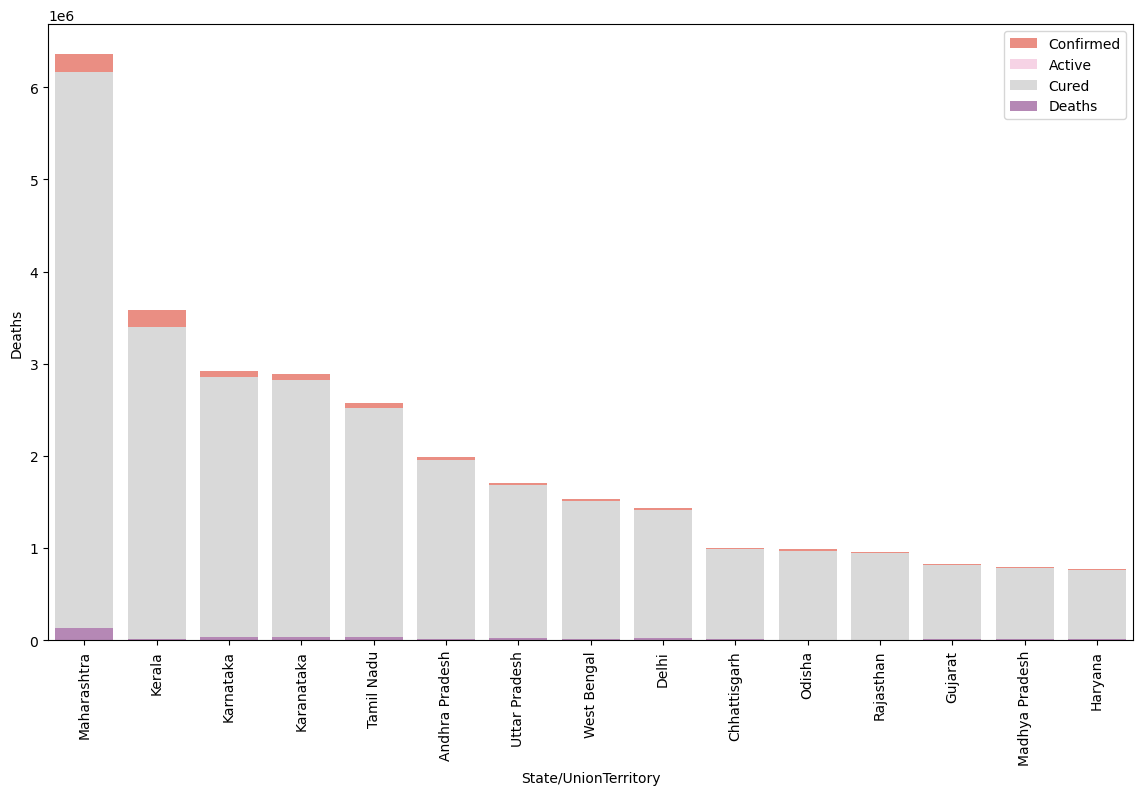

In [74]:
state_cases=state_cases.sort_values('Confirmed', ascending= False).fillna(0)
state_cases=state_cases.head(15)
state_cases
plt.figure(figsize=(14,8))
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Confirmed',color=sns.color_palette('Set3')[3],label='Confirmed')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Active',color=sns.color_palette('Set3')[7],label='Active')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Cured',color=sns.color_palette('Set3')[8],label='Cured')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Deaths',color=sns.color_palette('Set3')[9],label='Deaths')
plt.xticks(rotation=90)
plt.legend();

In [75]:
Con_date=df.groupby(['Confirmed'])['Date'].max().reset_index()
Con_date

Confirmed       Date
0              0 2021-01-18
1              1 2020-06-03
2              2 2020-06-11
3              3 2020-06-06
4              4 2020-06-03
...          ...        ...
14966    6341759 2021-08-07
14967    6347820 2021-08-08
14968    6353328 2021-08-09
14969    6357833 2021-08-10
14970    6363442 2021-08-11

[14971 rows x 2 columns]

In [76]:
df.State.value_counts().sort_values() 

Telangana                                    101
Dadra and Nagar Haveli and Daman and Diu     153
Lakshadweep                                  195
Ladakh                                       294
Sikkim                                       394
Manipur                                      406
Meghalaya                                    409
Tripura                                      447
Nagaland                                     447
Andaman and Nicobar Islands                  453
Mizoram                                      465
Assam                                        469
Arunachal Pradesh                            477
Puducherry                                   478
Chandigarh                                   479
Chhattisgarh                                 482
Goa                                          483
Jharkhand                                    484
Himachal Pradesh                             487
Gujarat                                      487
Andhra Pradesh      

In [77]:
df_Haryana = df[df.State=='Haryana']
df_Haryana
df_Kerala = df[df.State=='Kerala']
df_Kerala
df_WestBengal = df[df.State=='West Bengal']
df_WestBengal
df_Maharashtra = df[df.State=='Maharashtra']
df_Maharashtra.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed        State  \
666 2020-04-05          Maharashtra     42      24        490  Maharashtra   
697 2020-04-06          Maharashtra     56      45        748  Maharashtra   
727 2020-04-07          Maharashtra     56      48        868  Maharashtra   
789 2020-04-09          Maharashtra    117      72       1135  Maharashtra   
820 2020-04-10          Maharashtra    125      97       1364  Maharashtra   

     TotalSamples Negative  Positive  Day  Month  Year  
666         16008    14837       0.0    5      4  2020  
697         17563    15808     868.0    6      4  2020  
727         20877    19290    1018.0    7      4  2020  
789         20877    19290     868.0    9      4  2020  
820         30000    28865    1135.0   10      4  2020

<AxesSubplot:title={'center':'Haryana dataset'}>

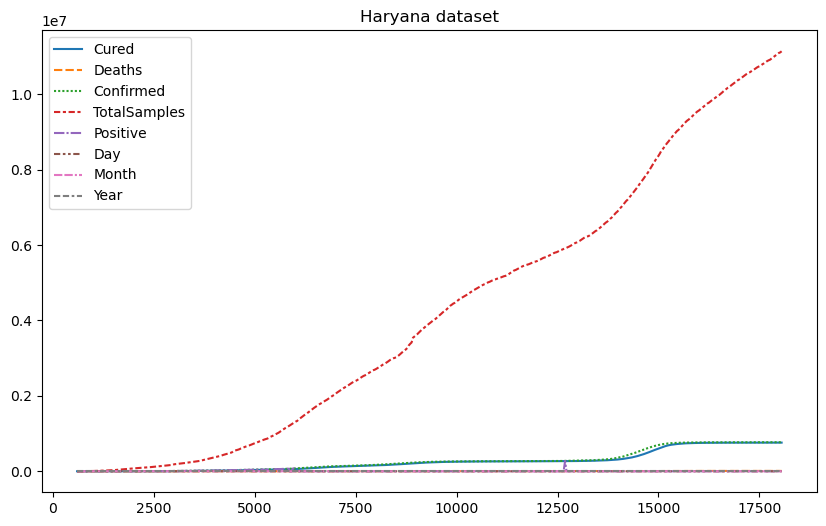

In [78]:
plt.figure(figsize=(10,6))

plt.title("Haryana dataset") 
sns.lineplot(data=df_Haryana)

<AxesSubplot:title={'center':'Maharashtra dataset'}>

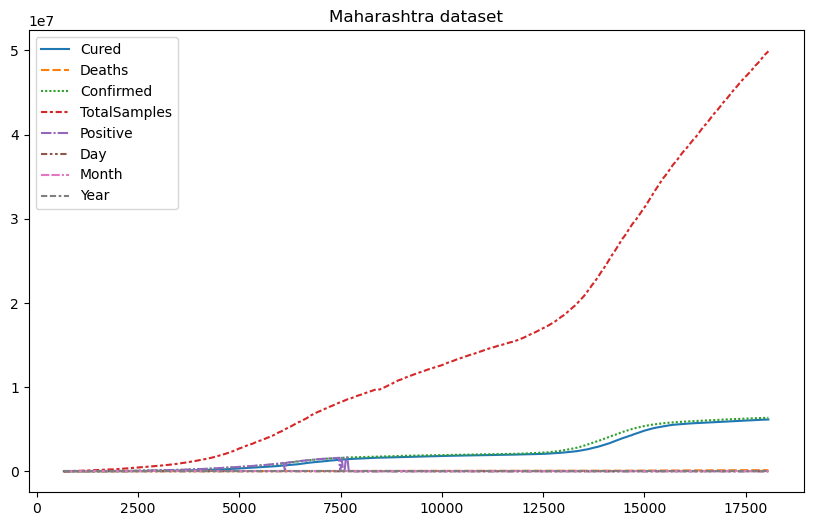

In [79]:
plt.figure(figsize=(10,6))

plt.title("Maharashtra dataset")
sns.lineplot(data=df_Maharashtra)

In [80]:
df_by_State = df.groupby('State')[['TotalSamples']].sum().reset_index()
df_by_State

State  TotalSamples
0                                          0  0.000000e+00
1                Andaman and Nicobar Islands  8.747008e+07
2                             Andhra Pradesh  4.967773e+09
3                          Arunachal Pradesh  1.636096e+08
4                                      Assam  2.853509e+09
5                                      Bihar  7.392796e+09
6                                 Chandigarh  9.974705e+07
7                               Chhattisgarh  1.863129e+09
8   Dadra and Nagar Haveli and Daman and Diu  6.291450e+06
9                                      Delhi  4.310596e+09
10                                       Goa  1.979067e+08
11                                   Gujarat  4.623914e+09
12                                   Haryana  2.056736e+09
13                          Himachal Pradesh  4.244486e+08
14                         Jammu and Kashmir  1.960284e+09
15                                 Jharkhand  2.053512e+09
16                                 Karnataka  6.736115e+09
17                                    Kerala  4.269006e+09
18                                    Ladakh  4.213546e+07
19                               Lakshadweep  2.001715e+07
20                            Madhya Pradesh  2.298458e+09
21                               Maharashtra  7.334574e+09
22                                   Manipur  1.855130e+08
23                                 Meghalaya  1.251595e+08
24                                   Mizoram  8.460259e+07
25                                  Nagaland  5.181064e+07
26                                    Odisha  2.965651e+09
27                                Puducherry  2.383986e+08
28                                    Punjab  2.026576e+09
29                                 Rajasthan  2.520540e+09
30                                    Sikkim  2.978195e+07
31                                Tamil Nadu  6.711189e+09
32                                 Telangana  1.789588e+09
33                                   Tripura  2.467333e+08
34                             Uttar Pradesh  1.138818e+10
35                               Uttarakhand  9.792698e+08
36                               West Bengal  3.051636e+09

Text(0, 0.5, 'TotalSamples')

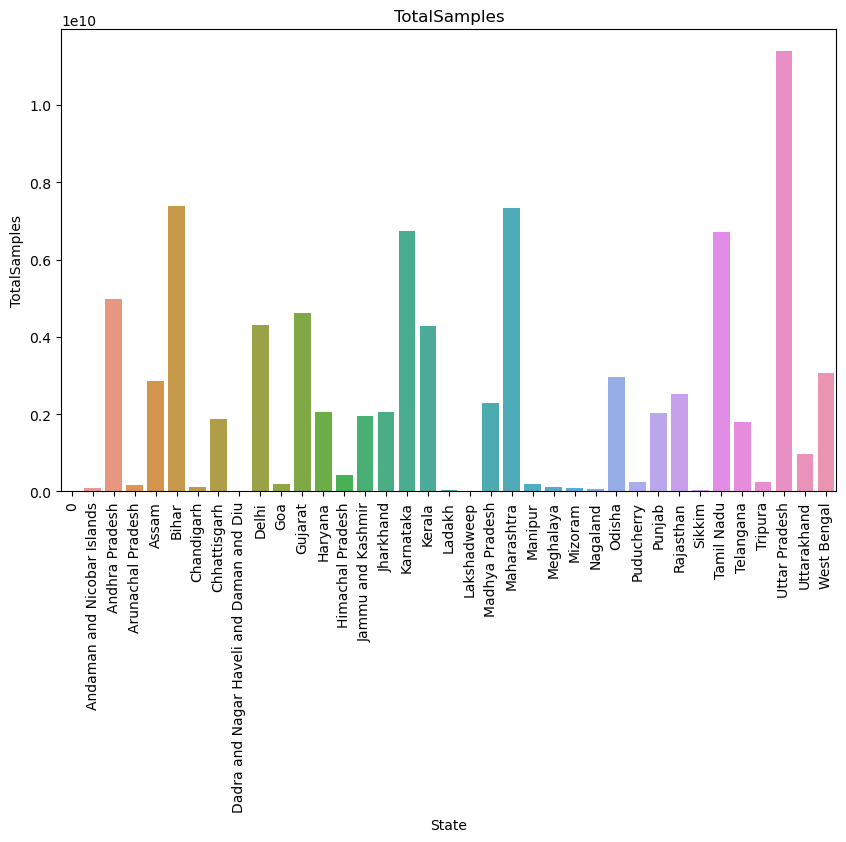

In [81]:
plt.figure(figsize=(10,6))

plt.title("TotalSamples")
sns.barplot(x=df_by_State["State"], y=df_by_State['TotalSamples'])
plt.xticks(rotation=90)

plt.ylabel("TotalSamples")

Uttar Pradesh has the highest TotalSample collection

In [82]:
CovidCases=df.groupby("Date")[["Cured","Deaths","Confirmed"]].sum().reset_index()

In [83]:
fig=px.line(CovidCases,x='Date',y=CovidCases.columns[1:4],)
fig.update_layout(
    title="Total Confirmed cases VS Total Cured Cases VS Total Deaths",
    xaxis_title="Time Period",
    yaxis_title="Cases",
    legend_title="Cases",
    font=dict(
        size=14
    )
)
fig.layout.template = 'presentation'
fig.show()

In [84]:
df_by_Deaths = df.groupby('State')[['Deaths']].sum().reset_index()
df_by_Deaths

State    Deaths
0                                          0   1082659
1                Andaman and Nicobar Islands     26878
2                             Andhra Pradesh   2925738
3                          Arunachal Pradesh     26521
4                                      Assam    632837
5                                      Bihar   1102659
6                                 Chandigarh    143537
7                               Chhattisgarh   2050376
8   Dadra and Nagar Haveli and Daman and Diu       184
9                                      Delhi   4918053
10                                       Goa    444637
11                                   Gujarat   2200496
12                                   Haryana   1493145
13                          Himachal Pradesh    487794
14                         Jammu and Kashmir    835276
15                                 Jharkhand    742441
16                                 Karnataka   6015253
17                                    Kerala   1870170
18                                    Ladakh     28419
19                               Lakshadweep      3857
20                            Madhya Pradesh   1777702
21                               Maharashtra  23587673
22                                   Manipur    162707
23                                 Meghalaya     94545
24                                   Mizoram      9152
25                                  Nagaland     57668
26                                    Odisha    784249
27                                Puducherry    309685
28                                    Punjab   2769226
29                                 Rajasthan   1464135
30                                    Sikkim     46888
31                                Tamil Nadu   5882268
32                                 Telangana    345817
33                                   Tripura    140172
34                             Uttar Pradesh   4118843
35                               Uttarakhand    978633
36                               West Bengal   3828714

<function matplotlib.pyplot.show(close=None, block=None)>

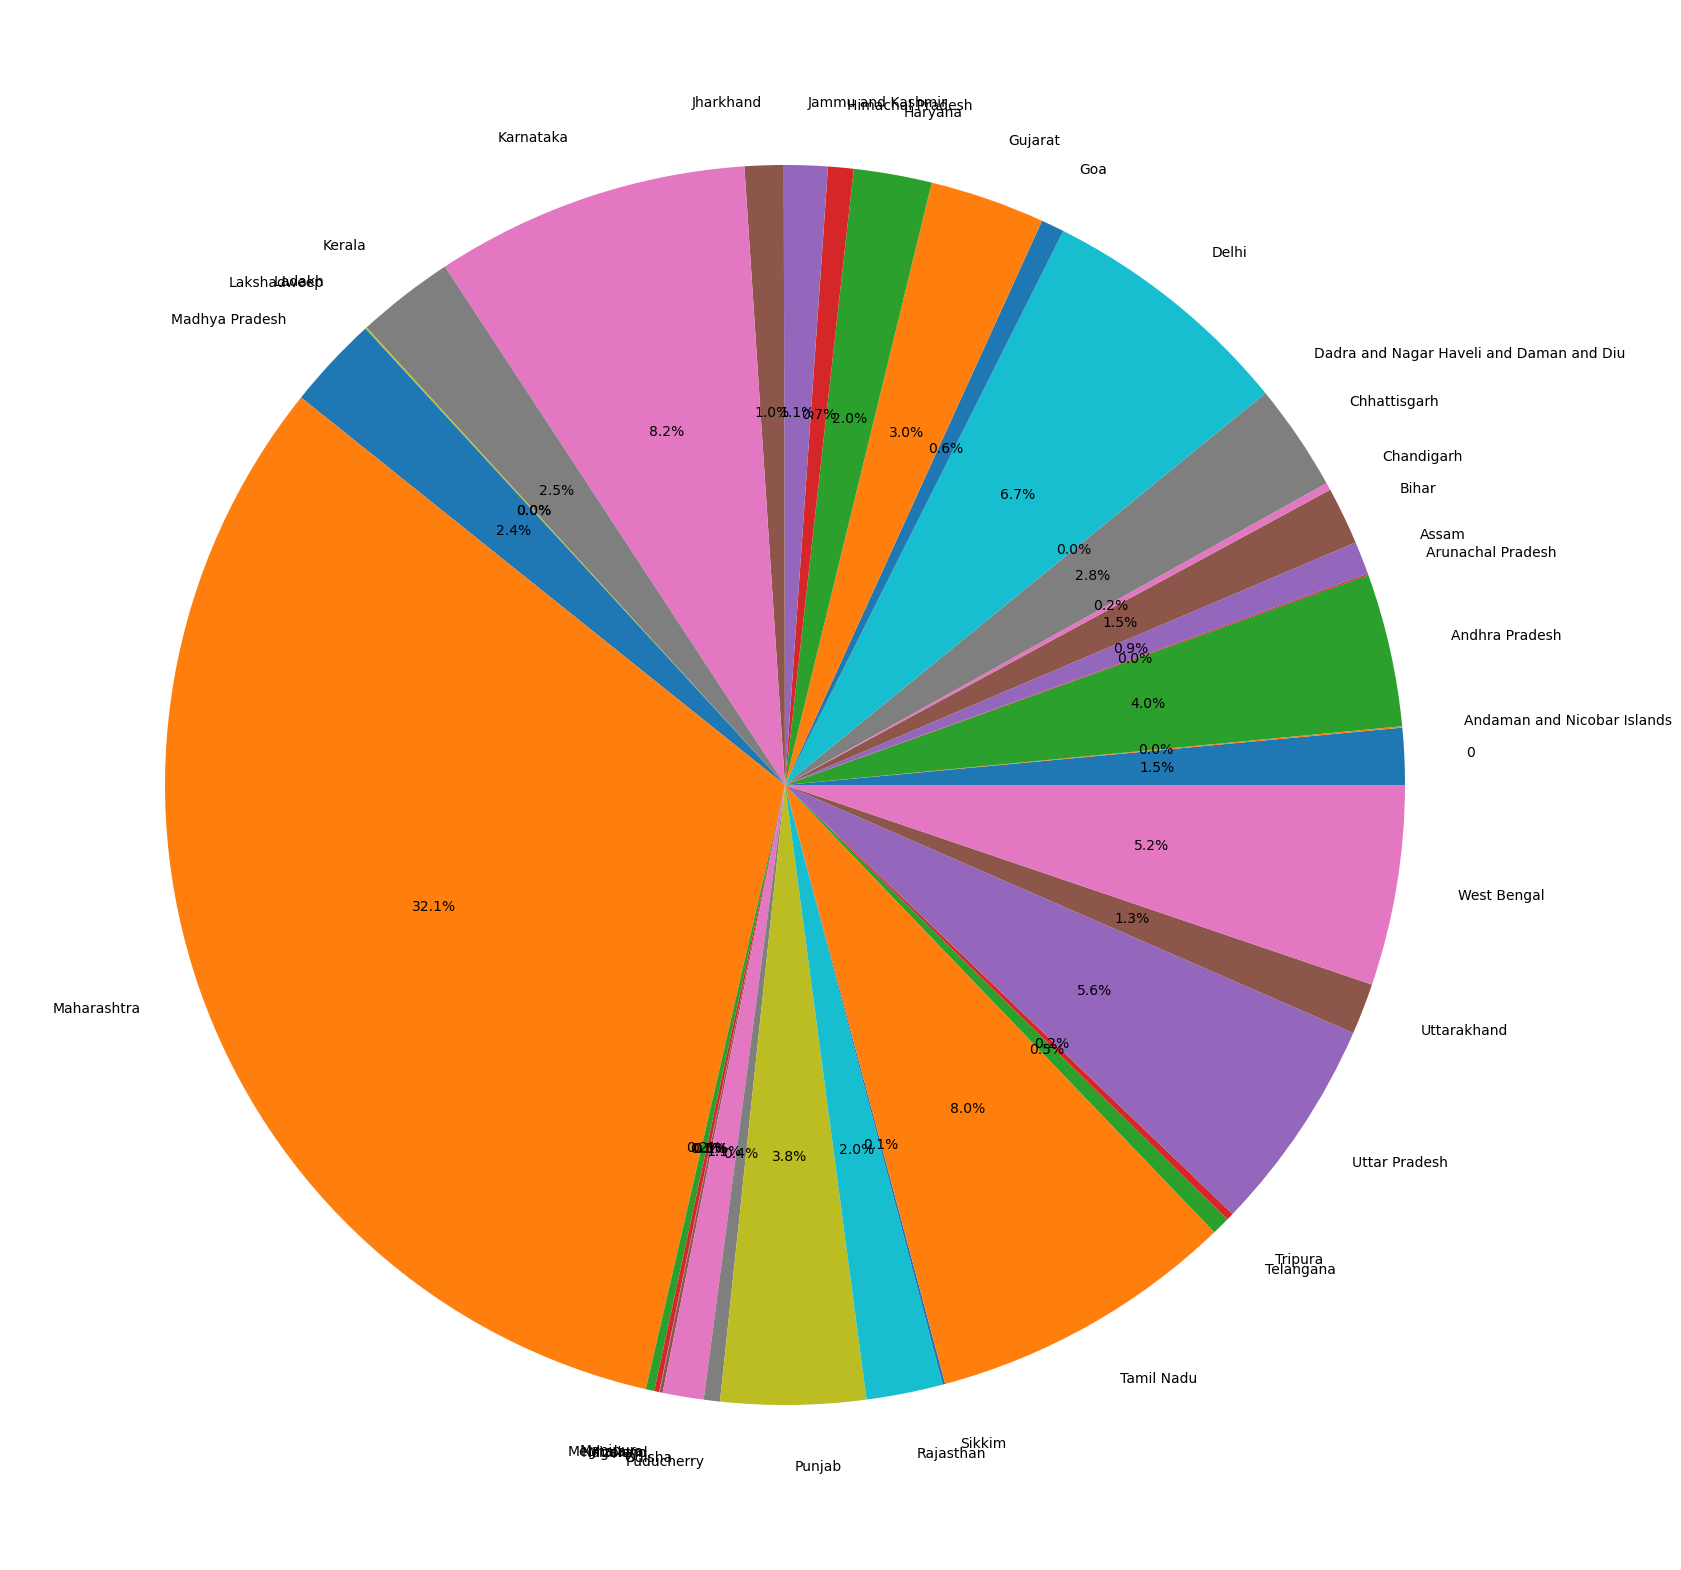

In [85]:
plt.figure(figsize=(20,30))
plt.pie(df_by_Deaths["Deaths"],labels=df_by_Deaths["State"],autopct="%1.1f%%")
plt.show

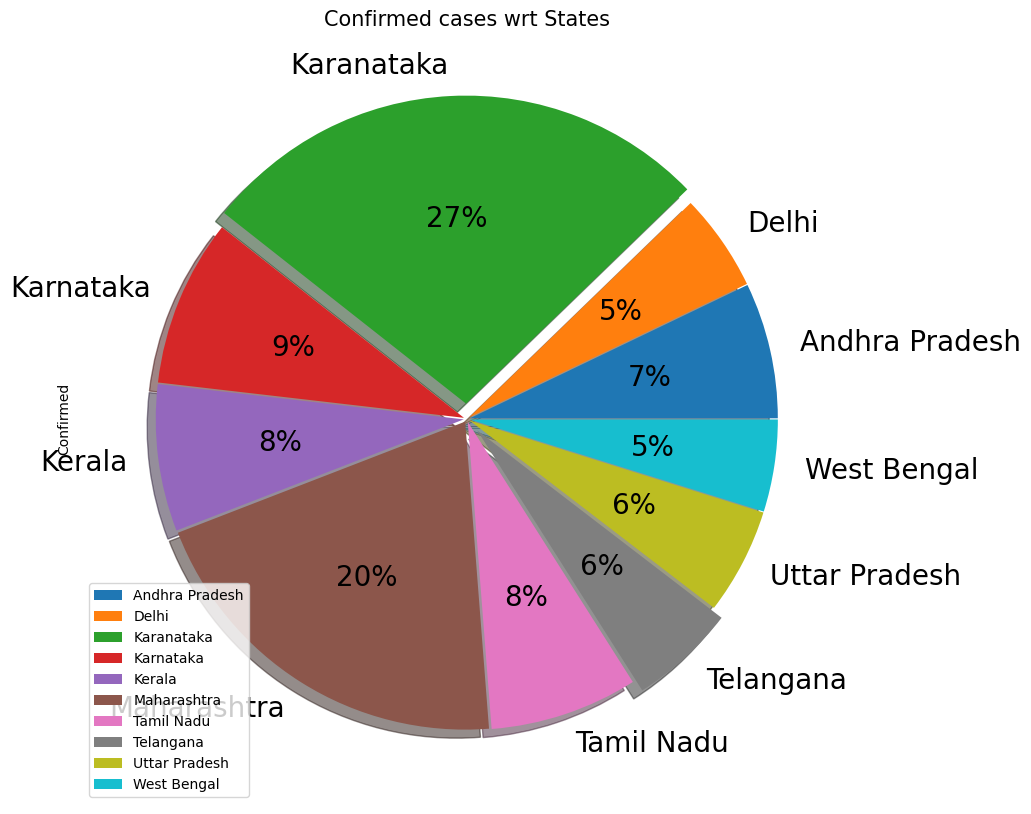

In [86]:
fig = plt.figure(figsize=(20,10))
df_t=df.groupby(['State/UnionTerritory']).agg({'Confirmed':np.mean})
df_t1=df_t.nlargest(10, ['Confirmed'])
df_t1.groupby(["State/UnionTerritory"]).sum()["Confirmed"].plot(kind='pie',rot=0,autopct='%1.0f%%', textprops={'fontsize': 20},explode=[0.01,0.01,0.05,0.01,0.01,0.01,0.01,0.05,0.01,0.01],shadow=True)
plt.title("Confirmed cases wrt States",fontsize=15)
plt.legend()

In [87]:
df.corr()

Cured    Deaths  Confirmed  TotalSamples  Positive       Day  \
Cured         1.000000  0.917530   0.997751      0.773349  0.050717 -0.006430   
Deaths        0.917530  1.000000   0.918346      0.639107  0.107352 -0.004573   
Confirmed     0.997751  0.918346   1.000000      0.768729  0.068165 -0.006011   
TotalSamples  0.773349  0.639107   0.768729      1.000000  0.006701 -0.008039   
Positive      0.050717  0.107352   0.068165      0.006701  1.000000  0.002779   
Day          -0.006430 -0.004573  -0.006011     -0.008039  0.002779  1.000000   
Month        -0.010734  0.005362  -0.008689     -0.056651  0.080016 -0.020275   
Year          0.337683  0.242641   0.332217      0.424269 -0.058075 -0.050015   

                 Month      Year  
Cured        -0.010734  0.337683  
Deaths        0.005362  0.242641  
Confirmed    -0.008689  0.332217  
TotalSamples -0.056651  0.424269  
Positive      0.080016 -0.058075  
Day          -0.020275 -0.050015  
Month         1.000000 -0.580918  
Year         -0.580918  1.000000

Text(0.5, 1.0, 'Heatmap of Attributes to check the correlation')

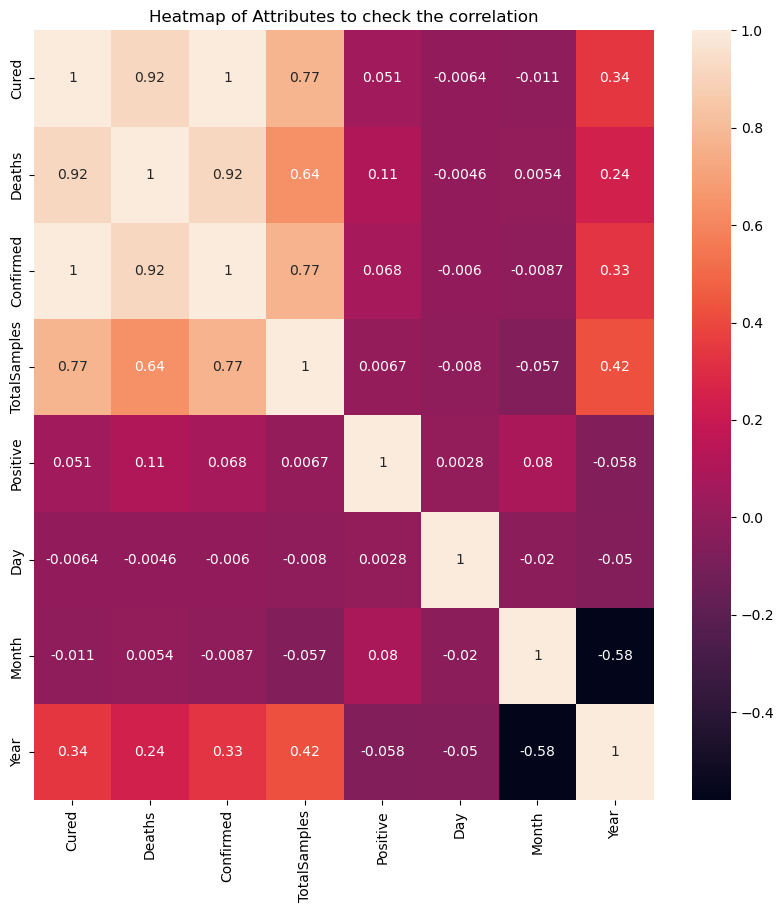

In [88]:
heatmap=df.iloc[:,:]

heatmap_corr=heatmap.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_corr,annot=True)
plt.title("Heatmap of Attributes to check the correlation")

In [89]:
df_vacc.head()

Updated On  State  Total Doses Administered  Sessions   Sites   \
0 2021-01-16  India                   48276.0    3455.0   2957.0   
1 2021-01-17  India                   58604.0    8532.0   4954.0   
2 2021-01-18  India                   99449.0   13611.0   6583.0   
3 2021-01-19  India                  195525.0   17855.0   7951.0   
4 2021-01-20  India                  251280.0   25472.0  10504.0   

   First Dose Administered  Second Dose Administered  \
0                  48276.0                       0.0   
1                  58604.0                       0.0   
2                  99449.0                       0.0   
3                 195525.0                       0.0   
4                 251280.0                       0.0   

   Male (Doses Administered)  Female (Doses Administered)  \
0                        NaN                          NaN   
1                        NaN                          NaN   
2                        NaN                          NaN   
3                        NaN                          NaN   
4                        NaN                          NaN   

   Transgender (Doses Administered)  ...  18-44 Years (Doses Administered)  \
0                               NaN  ...                               NaN   
1                               NaN  ...                               NaN   
2                               NaN  ...                               NaN   
3                               NaN  ...                               NaN   
4                               NaN  ...                               NaN   

   45-60 Years (Doses Administered)  60+ Years (Doses Administered)  \
0                               NaN                             NaN   
1                               NaN                             NaN   
2                               NaN                             NaN   
3                               NaN                             NaN   
4                               NaN                             NaN   

   18-44 Years(Individuals Vaccinated)  45-60 Years(Individuals Vaccinated)  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                                  NaN   

   60+ Years(Individuals Vaccinated)  Male(Individuals Vaccinated)  \
0                                NaN                       23757.0   
1                                NaN                       27348.0   
2                                NaN                       41361.0   
3                                NaN                       81901.0   
4                                NaN                       98111.0   

   Female(Individuals Vaccinated)  Transgender(Individuals Vaccinated)  \
0                         24517.0                                  2.0   
1                         31252.0                                  4.0   
2                         58083.0                                  5.0   
3                        113613.0                                 11.0   
4                        153145.0                                 24.0   

   Total Individuals Vaccinated  
0                       48276.0  
1                       58604.0  
2                       99449.0  
3                      195525.0  
4                      251280.0  

[5 rows x 24 columns]

In [90]:
df_vacc.isna().sum()

Updated On                                0
State                                     0
Total Doses Administered                224
Sessions                                224
 Sites                                  224
First Dose Administered                 224
Second Dose Administered                224
Male (Doses Administered)               384
Female (Doses Administered)             384
Transgender (Doses Administered)        384
 Covaxin (Doses Administered)           224
CoviShield (Doses Administered)         224
Sputnik V (Doses Administered)         4850
AEFI                                   2407
18-44 Years (Doses Administered)       6143
45-60 Years (Doses Administered)       6143
60+ Years (Doses Administered)         6143
18-44 Years(Individuals Vaccinated)    4112
45-60 Years(Individuals Vaccinated)    4111
60+ Years(Individuals Vaccinated)      4111
Male(Individuals Vaccinated)           7685
Female(Individuals Vaccinated)         7685
Transgender(Individuals Vaccinat

In [91]:
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Updated On                           7845 non-null   datetime64[ns]
 1   State                                7845 non-null   object        
 2   Total Doses Administered             7621 non-null   float64       
 3   Sessions                             7621 non-null   float64       
 4    Sites                               7621 non-null   float64       
 5   First Dose Administered              7621 non-null   float64       
 6   Second Dose Administered             7621 non-null   float64       
 7   Male (Doses Administered)            7461 non-null   float64       
 8   Female (Doses Administered)          7461 non-null   float64       
 9   Transgender (Doses Administered)     7461 non-null   float64       
 10   Covaxin (Do

In [92]:
df_vacc.describe()

Total Doses Administered      Sessions        Sites   \
count              7.621000e+03  7.621000e+03   7621.000000   
mean               9.188171e+06  4.792358e+05   2282.872064   
std                3.746180e+07  1.911511e+06   7275.973730   
min                7.000000e+00  0.000000e+00      0.000000   
25%                1.356570e+05  6.004000e+03     69.000000   
50%                8.182020e+05  4.547000e+04    597.000000   
75%                6.625243e+06  3.428690e+05   1708.000000   
max                5.132284e+08  3.501031e+07  73933.000000   

       First Dose Administered  Second Dose Administered  \
count             7.621000e+03              7.621000e+03   
mean              7.414415e+06              1.773755e+06   
std               2.995209e+07              7.570382e+06   
min               7.000000e+00              0.000000e+00   
25%               1.166320e+05              1.283100e+04   
50%               6.614590e+05              1.388180e+05   
75%               5.387805e+06              1.166434e+06   
max               4.001504e+08              1.130780e+08   

       Male (Doses Administered)  Female (Doses Administered)  \
count               7.461000e+03                 7.461000e+03   
mean                3.620156e+06                 3.168416e+06   
std                 1.737938e+07                 1.515310e+07   
min                 0.000000e+00                 2.000000e+00   
25%                 5.655500e+04                 5.210700e+04   
50%                 3.897850e+05                 3.342380e+05   
75%                 2.735777e+06                 2.561513e+06   
max                 2.701636e+08                 2.395186e+08   

       Transgender (Doses Administered)   Covaxin (Doses Administered)  \
count                       7461.000000                   7.621000e+03   
mean                        1162.978019                   1.044669e+06   
std                         5931.353995                   4.452259e+06   
min                            0.000000                   0.000000e+00   
25%                            8.000000                   0.000000e+00   
50%                          113.000000                   1.185100e+04   
75%                          800.000000                   7.579300e+05   
max                        98275.000000                   6.236742e+07   

       CoviShield (Doses Administered)  ...  18-44 Years (Doses Administered)  \
count                     7.621000e+03  ...                      1.702000e+03   
mean                      8.126553e+06  ...                      8.773958e+06   
std                       3.298414e+07  ...                      2.660829e+07   
min                       7.000000e+00  ...                      2.662400e+04   
25%                       1.331340e+05  ...                      4.344842e+05   
50%                       7.567360e+05  ...                      3.095970e+06   
75%                       6.007817e+06  ...                      7.366241e+06   
max                       4.468251e+08  ...                      2.243304e+08   

       45-60 Years (Doses Administered)  60+ Years (Doses Administered)  \
count                      1.702000e+03                    1.702000e+03   
mean                       7.442161e+06                    5.641605e+06   
std                        2.225999e+07                    1.681650e+07   
min                        1.681500e+04                    9.994000e+03   
25%                        2.326275e+05                    1.285605e+05   
50%                        2.695938e+06                    1.805696e+06   
75%                        6.969726e+06                    5.294763e+06   
max                        1.667575e+08                    1.186927e+08   

       18-44 Years(Individuals Vaccinated)  \
count                         3.733000e+03   
mean                          1.395895e+06   
std                           5.501454e+06   
min                           1.059000e+03   
25%      

In [93]:
df_vacc = df_vacc.drop(columns=['18-44 Years (Doses Administered)','45-60 Years (Doses Administered)','60+ Years (Doses Administered)','AEFI'],axis = 1)

In [94]:
df_vacc.fillna(0,inplace=True)
df_vacc.head()

Updated On  State  Total Doses Administered  Sessions   Sites   \
0 2021-01-16  India                   48276.0    3455.0   2957.0   
1 2021-01-17  India                   58604.0    8532.0   4954.0   
2 2021-01-18  India                   99449.0   13611.0   6583.0   
3 2021-01-19  India                  195525.0   17855.0   7951.0   
4 2021-01-20  India                  251280.0   25472.0  10504.0   

   First Dose Administered  Second Dose Administered  \
0                  48276.0                       0.0   
1                  58604.0                       0.0   
2                  99449.0                       0.0   
3                 195525.0                       0.0   
4                 251280.0                       0.0   

   Male (Doses Administered)  Female (Doses Administered)  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        0.0                          0.0   

   Transgender (Doses Administered)   Covaxin (Doses Administered)  \
0                               0.0                          579.0   
1                               0.0                          635.0   
2                               0.0                         1299.0   
3                               0.0                         3017.0   
4                               0.0                         3946.0   

   CoviShield (Doses Administered)  Sputnik V (Doses Administered)  \
0                          47697.0                             0.0   
1                          57969.0                             0.0   
2                          98150.0                             0.0   
3                         192508.0                             0.0   
4                         247334.0                             0.0   

   18-44 Years(Individuals Vaccinated)  45-60 Years(Individuals Vaccinated)  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   60+ Years(Individuals Vaccinated)  Male(Individuals Vaccinated)  \
0                                0.0                       23757.0   
1                                0.0                       27348.0   
2                                0.0                       41361.0   
3                                0.0                       81901.0   
4                                0.0                       98111.0   

   Female(Individuals Vaccinated)  Transgender(Individuals Vaccinated)  \
0                         24517.0                                  2.0   
1                         31252.0                                  4.0   
2                         58083.0                                  5.0   
3                        113613.0                                 11.0   
4                        153145.0                                 24.0   

   Total Individuals Vaccinated  
0                       48276.0  
1                       58604.0  
2                       99449.0  
3                      195525.0  
4                      251280.0

<AxesSubplot:xlabel='Updated On', ylabel='Total Doses Administered'>

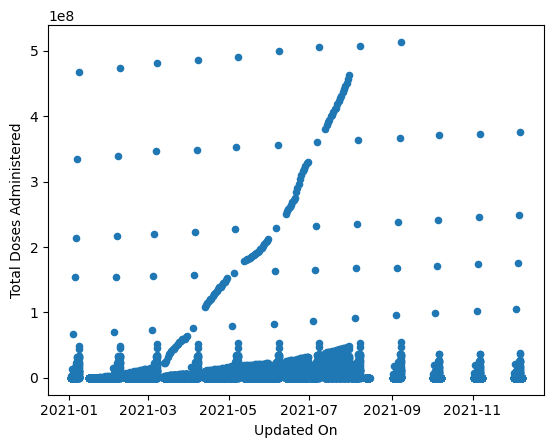

In [95]:
df_vacc.plot.scatter(x='Updated On',y='Total Doses Administered')

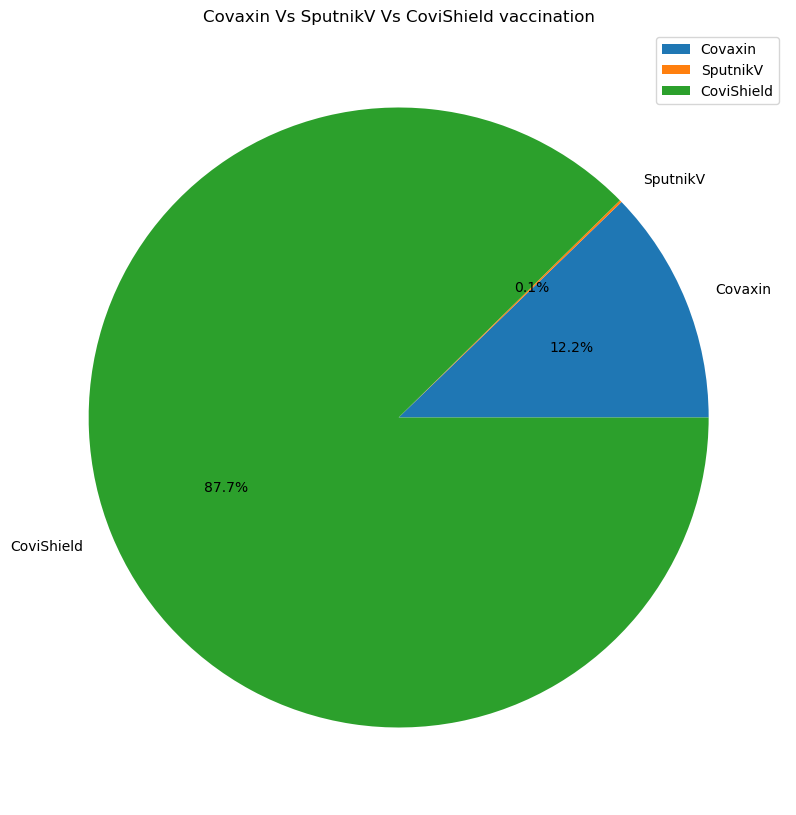

In [96]:
plt.figure(figsize=(10,20))
Covaxin = df_vacc[" Covaxin (Doses Administered)"].max()
SputnikV = df_vacc['Sputnik V (Doses Administered)'].max() 
CoviShield =df_vacc["CoviShield (Doses Administered)"].max()
x = np.array([Covaxin,SputnikV,CoviShield])
plt.pie(x,labels =  ['Covaxin','SputnikV','CoviShield'],autopct="%1.1f%%")
plt.title('Covaxin Vs SputnikV Vs CoviShield vaccination')
plt.legend()
plt.show()

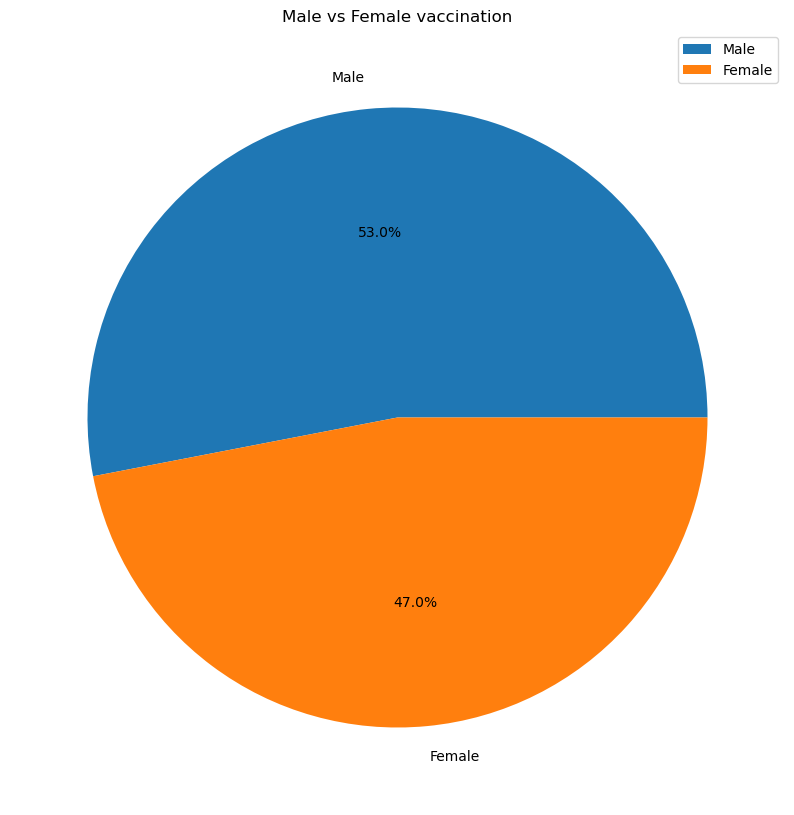

In [97]:
plt.figure(figsize=(10,20))
male = df_vacc['Male(Individuals Vaccinated)'].mean()
female = df_vacc['Female(Individuals Vaccinated)'].mean()
x = np.array([male,female])
plt.pie(x,labels =  ['Male','Female'],autopct="%1.1f%%")
plt.title('Male vs Female vaccination')
plt.legend()
plt.show()

In [98]:
df1_Odisha=df_vacc[df_vacc['State']=='Odisha']
df1_Maharashtra=df_vacc[df_vacc['State']=='Maharashtra']
df1_Delhi=df_vacc[df_vacc['State']=='Delhi']

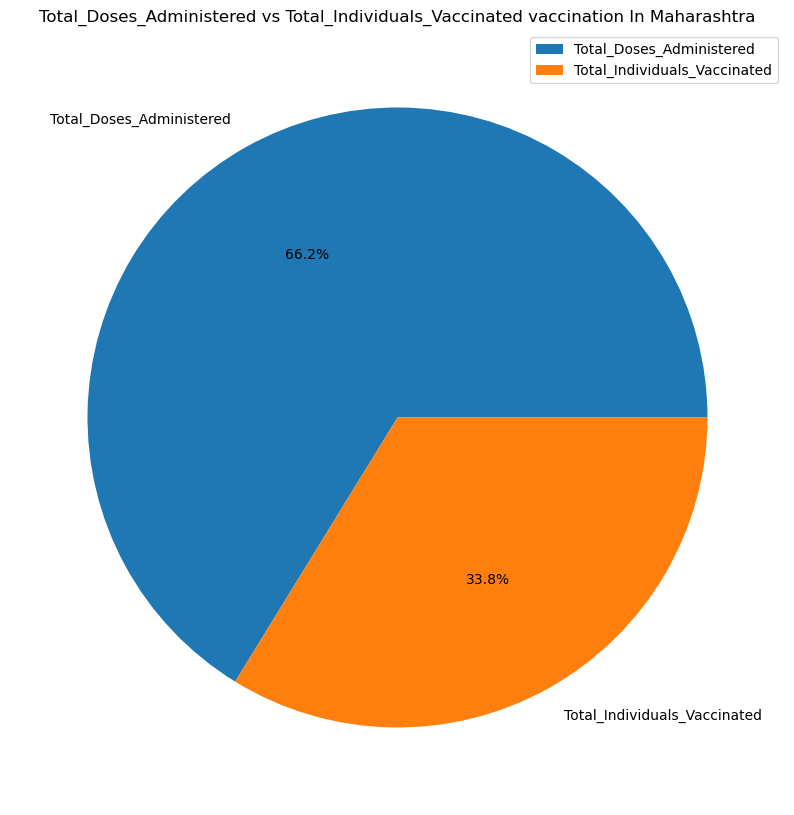

In [99]:
plt.figure(figsize=(10,20))
Total_Doses = df1_Maharashtra["Total Doses Administered"].max() 
Total_Individuals = df1_Maharashtra["Total Individuals Vaccinated"].max()
x = np.array([Total_Doses,Total_Individuals])
plt.pie(x,labels =  ['Total_Doses_Administered','Total_Individuals_Vaccinated'],autopct="%1.1f%%")
plt.title('Total_Doses_Administered vs Total_Individuals_Vaccinated vaccination In Maharashtra')
plt.legend()
plt.show()

In [100]:
df.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed State  \
0 2020-01-30               Kerala      0       0          1     0   
1 2020-01-31               Kerala      0       0          1     0   
2 2020-02-01               Kerala      0       0          2     0   
3 2020-02-02               Kerala      0       0          3     0   
4 2020-02-03               Kerala      0       0          3     0   

   TotalSamples Negative  Positive  Day  Month  Year  
0             0        0       0.0   30      1  2020  
1             0        0       0.0   31      1  2020  
2             0        0       0.0    1      2  2020  
3             0        0       0.0    2      2  2020  
4             0        0       0.0    3      2  2020

In [101]:
df.describe()

Cured         Deaths     Confirmed  TotalSamples      Positive  \
count  1.811100e+04   18111.000000  1.811100e+04  1.811100e+04  1.811100e+04   
mean   2.786221e+05    4052.178621  3.010148e+05  4.757145e+06  1.745889e+04   
std    6.148774e+05   10918.816423  6.561346e+05  8.496938e+06  9.709808e+04   
min    0.000000e+00       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.358500e+03      32.000000  4.376000e+03  6.240150e+04  0.000000e+00   
50%    3.335800e+04     588.000000  3.977000e+04  5.603400e+05  0.000000e+00   
75%    2.788595e+05    3643.500000  3.001465e+05  6.074854e+06  2.450000e+02   
max    6.159676e+06  134201.000000  6.363442e+06  6.789786e+07  1.638961e+06   

                Day         Month          Year  
count  18111.000000  18111.000000  18111.000000  
mean      15.679145      6.207443   2020.443267  
std        8.836388      3.060116      0.496785  
min        1.000000      1.000000   2020.000000  
25%        8.000000      4.000000   2020.000000  
50%       16.000000      6.000000   2020.000000  
75%       23.000000      8.000000   2021.000000  
max       31.000000     12.000000   2021.000000

In [102]:
a=df.groupby(["State"])["Confirmed"].describe()
a

count          mean           std  \
State                                                                          
0                                         2168.0  5.438372e+04  2.328850e+05   
Andaman and Nicobar Islands                453.0  4.243755e+03  2.359979e+03   
Andhra Pradesh                             488.0  8.000889e+05  6.049950e+05   
Arunachal Pradesh                          477.0  1.491243e+04  1.253161e+04   
Assam                                      469.0  2.115785e+05  1.583198e+05   
Bihar                                      489.0  2.718430e+05  2.397058e+05   
Chandigarh                                 479.0  2.207944e+04  2.145995e+04   
Chhattisgarh                               482.0  3.377016e+05  3.549294e+05   
Dadra and Nagar Haveli and Daman and Diu   153.0  1.365438e+03  1.220891e+03   
Delhi                                      489.0  5.844190e+05  4.912416e+05   
Goa                                        483.0  5.811171e+04  5.546183e+04   
Gujarat                                    487.0  2.917323e+05  2.802199e+05   
Haryana                                    492.0  2.714968e+05  2.628296e+05   
Himachal Pradesh                           487.0  6.124139e+04  6.971588e+04   
Jammu and Kashmir                          489.0  1.181880e+05  1.024314e+05   
Jharkhand                                  484.0  1.273679e+05  1.174558e+05   
Karnataka                                  490.0  9.856480e+05  9.289050e+05   
Kerala                                     497.0  9.161319e+05  1.033205e+06   
Ladakh                                     294.0  9.109374e+03  7.752859e+03   
Lakshadweep                                195.0  4.641251e+03  4.194129e+03   
Madhya Pradesh                             492.0  2.756589e+05  2.742867e+05   
Maharashtra                                488.0  2.286583e+06  2.073045e+06   
Manipur                                    406.0  2.885522e+04  2.571636e+04   
Meghalaya                                  409.0  1.634594e+04  1.829301e+04   
Mizoram                                    465.0  5.980985e+03  8.976508e+03   
Nagaland                                   447.0  1.115458e+04  8.020317e+03   
Odisha                                     492.0  3.234582e+05  2.942750e+05   
Puducherry                                 478.0  4.164021e+04  3.799460e+04   
Punjab                                     491.0  2.023410e+05  2.019218e+05   
Rajasthan                                  491.0  3.287457e+05  3.263501e+05   
Sikkim                                     394.0  7.302048e+03  7.538475e+03   
Tamil Nadu                                 491.0  8.744330e+05  7.691256e+05   
Telangana                                  101.0  5.932834e+05  5.335482e+04   
Tripura                                    447.0  2.944497e+04  2.191540e+04   
Uttar Pradesh                              490.0  6.343157e+05  5.836390e+05   
Uttarakhand                                491.0  1.075311e+05  1.163735e+05   
West Bengal                                493.0  5.305729e+05  4.934677e+05   

                                               min        25%        50%  \
State                                                                      
0                                              0.0      13.00     2441.5   
Andaman and Nicobar Islands                   11.0    3223.00     4912.0   
Andhra Pradesh                                86.0  225155.00   873148.0   
Arunachal Pradesh                              1.0    2701.00    16536.0   
Assam                                          5.0   90740.00   215250.0   
Bihar                                         30.0   75294.00   239322.0   
Chandigarh                                    16.0    1350.50    18027.0   
Chhattisgarh                                   9.0   14073.00   254945.0   
Dadra and Nagar Haveli and Daman and Diu       1.0      88.00     1145.0   
Delhi                                        152.0  144127.00   597112.0   
Goa       

C:\Users\sanke\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

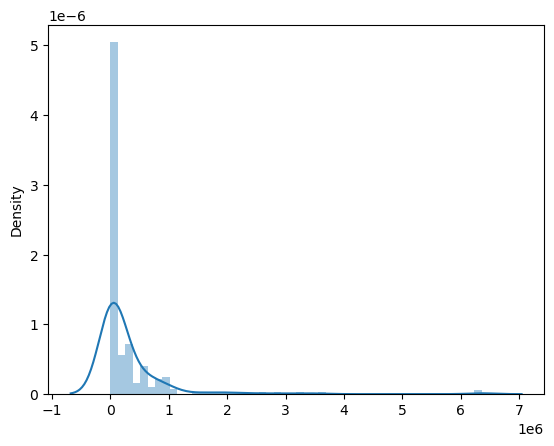

In [103]:
sns.distplot(a)

In [104]:
b=df.groupby(["State"])["Confirmed"].median()
b

State
0                                              2441.5
Andaman and Nicobar Islands                    4912.0
Andhra Pradesh                               873148.0
Arunachal Pradesh                             16536.0
Assam                                        215250.0
Bihar                                        239322.0
Chandigarh                                    18027.0
Chhattisgarh                                 254945.0
Dadra and Nagar Haveli and Daman and Diu       1145.0
Delhi                                        597112.0
Goa                                           49235.0
Gujarat                                      220168.0
Haryana                                      244592.0
Himachal Pradesh                              46201.0
Jammu and Kashmir                            114038.0
Jharkhand                                    110916.5
Karnataka                                    893505.0
Kerala                                       625767.0
Ladakh                